In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt

from tn_gradient.layer.sow import SoWLinear

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '8'

In [3]:
class LinearRegressionModel(nn.Module):
    def __init__(self, n_input_features, n_output_features):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(n_input_features, n_output_features, bias=False)

    def forward(self, x):
        return self.linear(x)
    
class SoWLinearRegressionModel(nn.Module):
    def __init__(self, n_input_features, n_output_features, rank, n_iter):
        super(SoWLinearRegressionModel, self).__init__()
        self.linear = SoWLinear(
            n_input_features, n_output_features,
            rank=rank, n_iter=n_iter,
            bias=False,
        )

    def forward(self, x):
        return self.linear(x)
    
def numel_model(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def project_grad(model):
    # Go through all the layers and call .project_grad if SoWLinear
    for layer in model.children():
        if isinstance(layer, SoWLinear):
            layer.project_grad()
        else:
            project_grad(layer)

In [4]:
in_dim = 64
out_dim = 64
batch_size = 64
n_samples = 100000
W = torch.tensor(np.random.randn(in_dim, out_dim), dtype=torch.float32).to('cuda')
b = torch.tensor(np.random.randn(out_dim), dtype=torch.float32).to('cuda')

_, S, _ = torch.linalg.svd(W)

x_trains = torch.tensor(np.random.randn(n_samples, in_dim), dtype=torch.float32).to('cuda')
y_trains = (torch.mm(x_trains, W) + b).to('cuda')

learning_rate = 0.025
ranks = [2, 4, 8, 16, 32]
n_iters = [1]
accumulation_steps = [50, 100, 400, 800]

dict_models = {}
dict_optimizers = {}

singular_values_sow = {}
numel_sow = {}

weight_ranks = {}

losses = []
losses_sow = {}

model = LinearRegressionModel(in_dim, out_dim).to('cuda')

from itertools import product
for rank, n_iter, acc_steps in product(ranks, n_iters, accumulation_steps):
    model_sow = SoWLinearRegressionModel(in_dim, out_dim, rank=rank, n_iter=n_iter).to('cuda')
    optimizer = optim.Adam(model_sow.parameters(), lr=learning_rate)
    dict_models[(rank, n_iter, acc_steps)] = model_sow
    dict_optimizers[(rank, n_iter, acc_steps)] = optimizer
    losses_sow[(rank, n_iter, acc_steps)] = []
    singular_values_sow[(rank, n_iter, acc_steps)] = []
    numel_sow[(rank, n_iter, acc_steps)] = []
    weight_ranks[(rank, n_iter, acc_steps)] = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

singular_values = []
numel_lreg = []

In [5]:
num_epochs = 5000

flash_steps = [1, 500, 1000, 1500, 2000, 3000, 4500, 5000]
flash_idx = 0
flash_idx_sow = 0

print("Num epochs: ", num_epochs)
for epoch in range(num_epochs):
    rand_idx = np.random.randint(0, n_samples, batch_size)
    x_train, y_train = x_trains[rand_idx], y_trains[rand_idx]
    
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if flash_idx < len(flash_steps):
        if epoch % flash_steps[flash_idx] == 0:
            weight = model.linear.weight.detach()
            _, S, _ = torch.linalg.svd(weight)
            singular_values.append(S)
            flash_idx += 1

    for key, model_sow in dict_models.items():
        rank, n_iter, acc_steps = key
        optimizer_sow = dict_optimizers[key]
        y_pred_sow = model_sow(x_train)
        loss_sow = criterion(y_pred_sow, y_train)
        optimizer_sow.zero_grad()
        loss_sow.backward()

        optimizer_sow.step()
        losses_sow[key].append(loss_sow.item())

        if epoch % acc_steps == 0 and epoch > 0:
            # print("Accumulation", epoch)
            for _, module in model_sow.named_modules():
                if isinstance(module, SoWLinear):
                    module.accumulate() 

        if flash_idx_sow < len(flash_steps):
            if epoch % flash_steps[flash_idx_sow] == 0 and epoch > 0:
                weight = torch.sum(torch.stack([a.detach() @ b.detach() for a, b in zip(model_sow.linear.downscale_weights, model_sow.linear.upscale_weights)]), dim=0).detach()
                if model_sow.linear.acc_upweight.numel() != 0:
                    weight += model_sow.linear.acc_downweight @ model_sow.linear.acc_upweight
                elif model_sow.linear.acc_downweight.numel() != 0:
                    weight += model_sow.linear.acc_downweight

                _, S, _ = torch.linalg.svd(weight)
                singular_values_sow[key].append(S)

                numel_sow[key].append(numel_model(model_sow))
                weight_ranks[key].append(torch.sum(S > 1e-6).item())

    if flash_idx_sow < len(flash_steps):
        if epoch % flash_steps[flash_idx_sow] == 0:
            flash_idx_sow += 1

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss Standard: {loss.item():.4f}, Loss SoW: {loss_sow.item():.4f}')


Num epochs:  5000
Epoch [100/5000], Loss Standard: 57.0150, Loss SoW: 8.6506
Epoch [200/5000], Loss Standard: 49.1684, Loss SoW: 8.3294
Epoch [300/5000], Loss Standard: 40.9788, Loss SoW: 7.8013
Epoch [400/5000], Loss Standard: 35.8060, Loss SoW: 7.8974
Epoch [500/5000], Loss Standard: 30.5343, Loss SoW: 8.6512
Epoch [600/5000], Loss Standard: 26.6837, Loss SoW: 8.3579
Epoch [700/5000], Loss Standard: 23.3462, Loss SoW: 8.4016
Epoch [800/5000], Loss Standard: 19.7979, Loss SoW: 7.8527
Epoch [900/5000], Loss Standard: 16.5533, Loss SoW: 0.9084
Epoch [1000/5000], Loss Standard: 14.8255, Loss SoW: 0.8980
Epoch [1100/5000], Loss Standard: 12.3529, Loss SoW: 0.8808
Epoch [1200/5000], Loss Standard: 10.7451, Loss SoW: 0.9138
Epoch [1300/5000], Loss Standard: 8.8165, Loss SoW: 0.9001
Epoch [1400/5000], Loss Standard: 8.2763, Loss SoW: 0.9108
Epoch [1500/5000], Loss Standard: 7.6292, Loss SoW: 1.0173
Epoch [1600/5000], Loss Standard: 5.9255, Loss SoW: 0.8671
Epoch [1700/5000], Loss Standard: 5

In [ ]:
import pickle

# Save the models, losses, singular values, and weight ranks
save = True
if save:
    with open('linear_regression_models4.pkl', 'wb') as f:
        pickle.dump(dict_models, f)

    with open('linear_regression_losses4.pkl', 'wb') as f:
        pickle.dump(losses, f)

    with open('linear_regression_losses_sow4.pkl', 'wb') as f:
        pickle.dump(losses_sow, f)

    with open('linear_regression_singular_values4.pkl', 'wb') as f:
        pickle.dump(singular_values, f)

    with open('linear_regression_singular_values_sow4.pkl', 'wb') as f:
        pickle.dump(singular_values_sow, f)

    with open('linear_regression_weight_ranks4.pkl', 'wb') as f:
        pickle.dump(weight_ranks, f)

load = False
if load:
    with open('linear_regression_models.pkl', 'rb') as f:
        dict_models = pickle.load(f)

    with open('linear_regression_losses.pkl', 'rb') as f:
        losses = pickle.load(f)

    with open('linear_regression_losses_sow.pkl', 'rb') as f:
        losses_sow = pickle.load(f)

    with open('linear_regression_singular_values.pkl', 'rb') as f:
        singular_values = pickle.load(f)

    with open('linear_regression_singular_values_sow.pkl', 'rb') as f:
        singular_values_sow = pickle.load(f)

    

/home/antoine/miniforge-pypy3/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


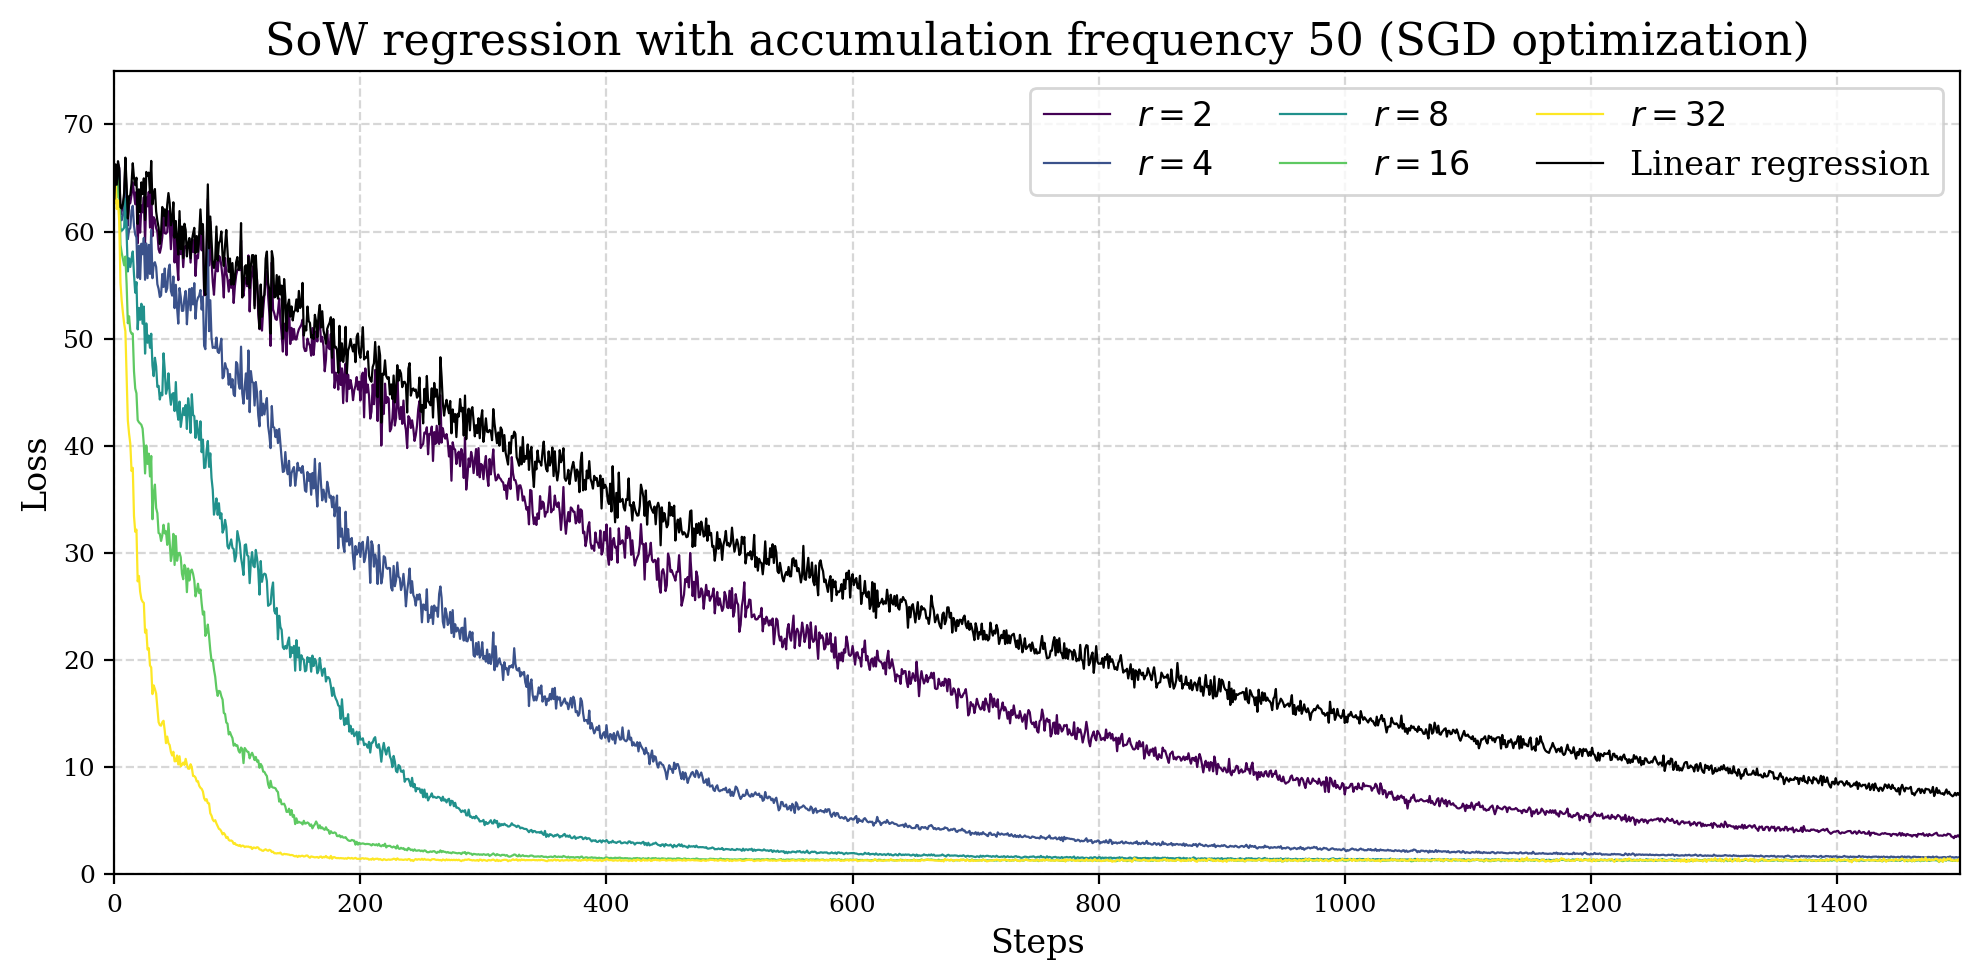

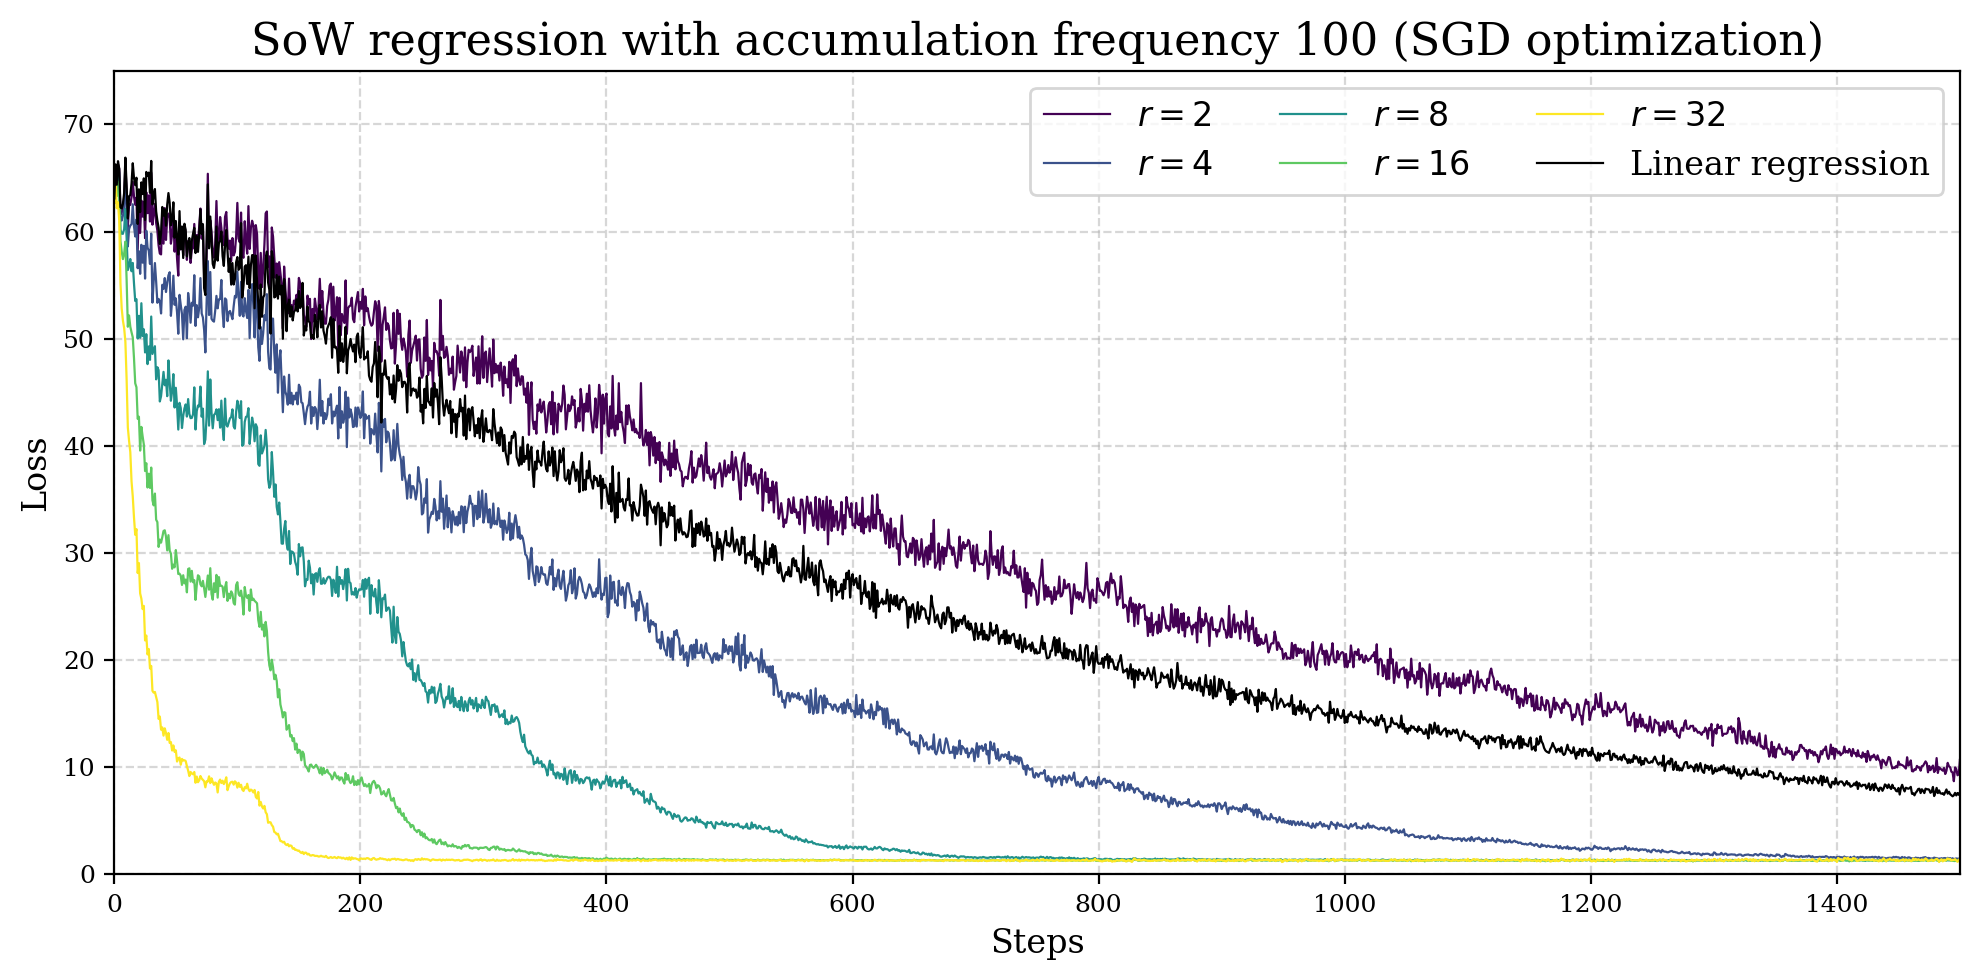

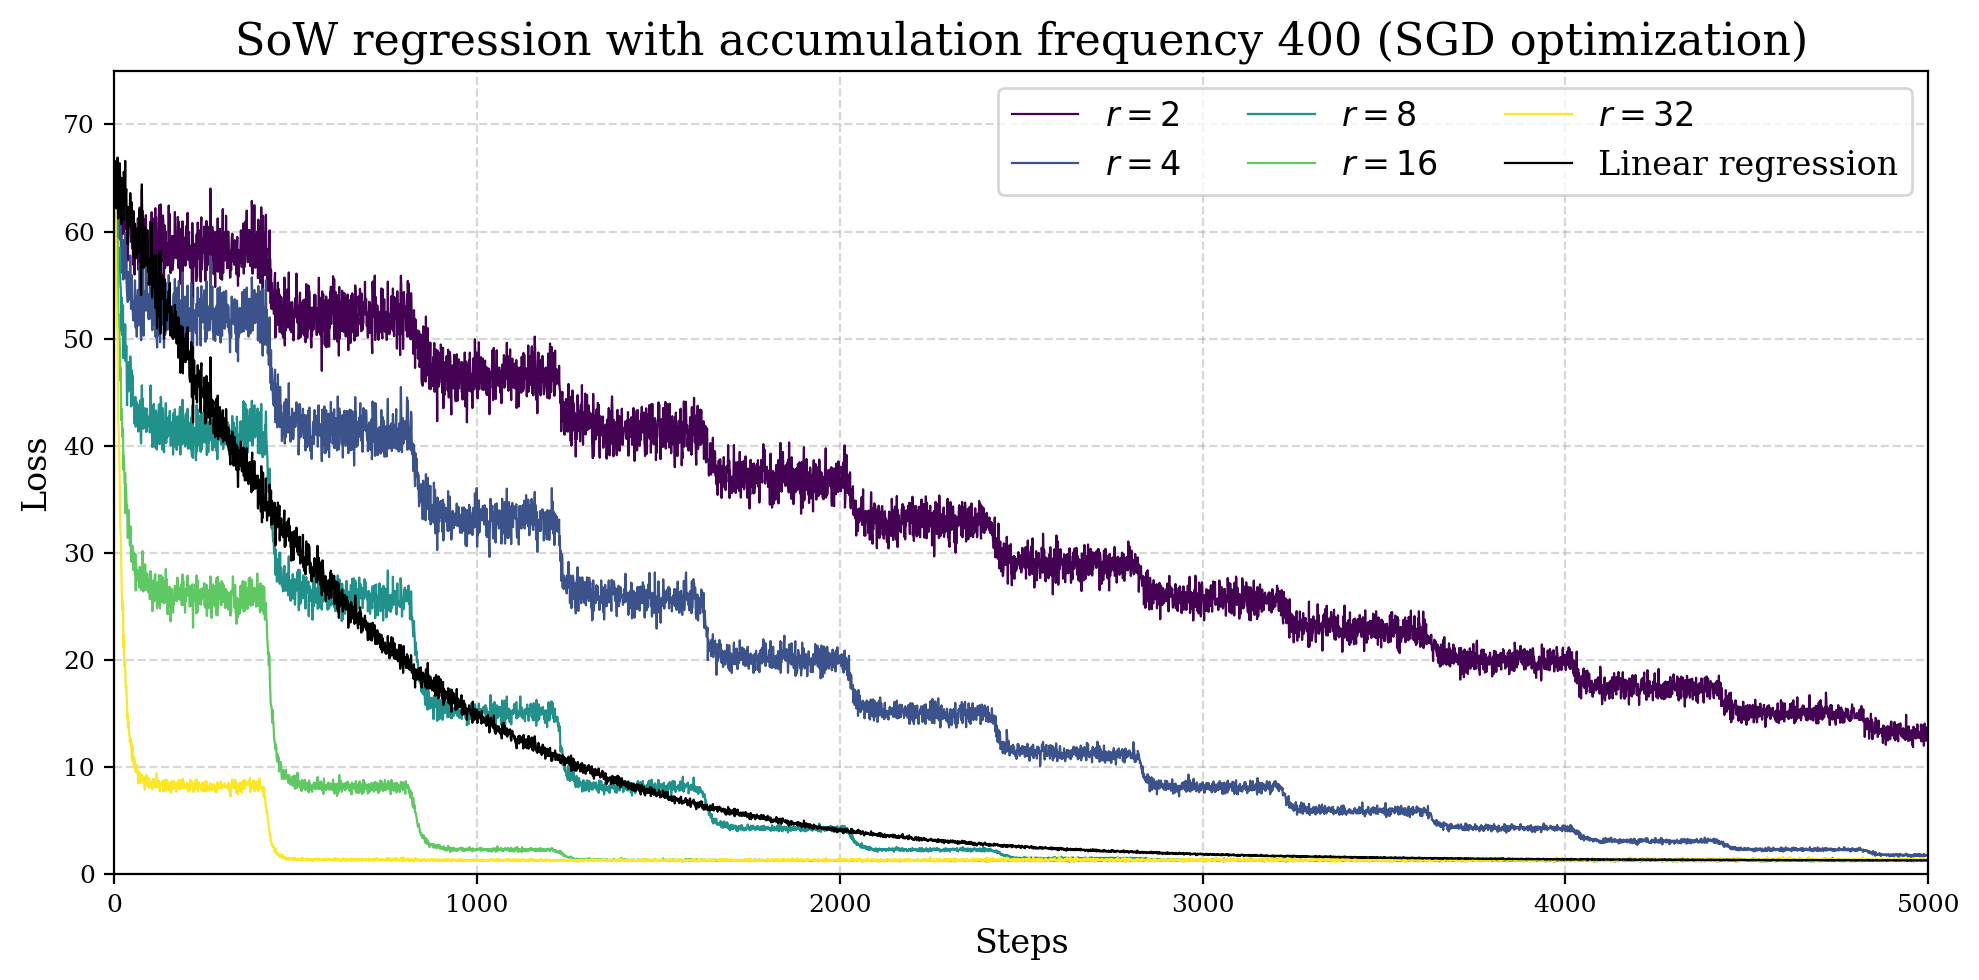

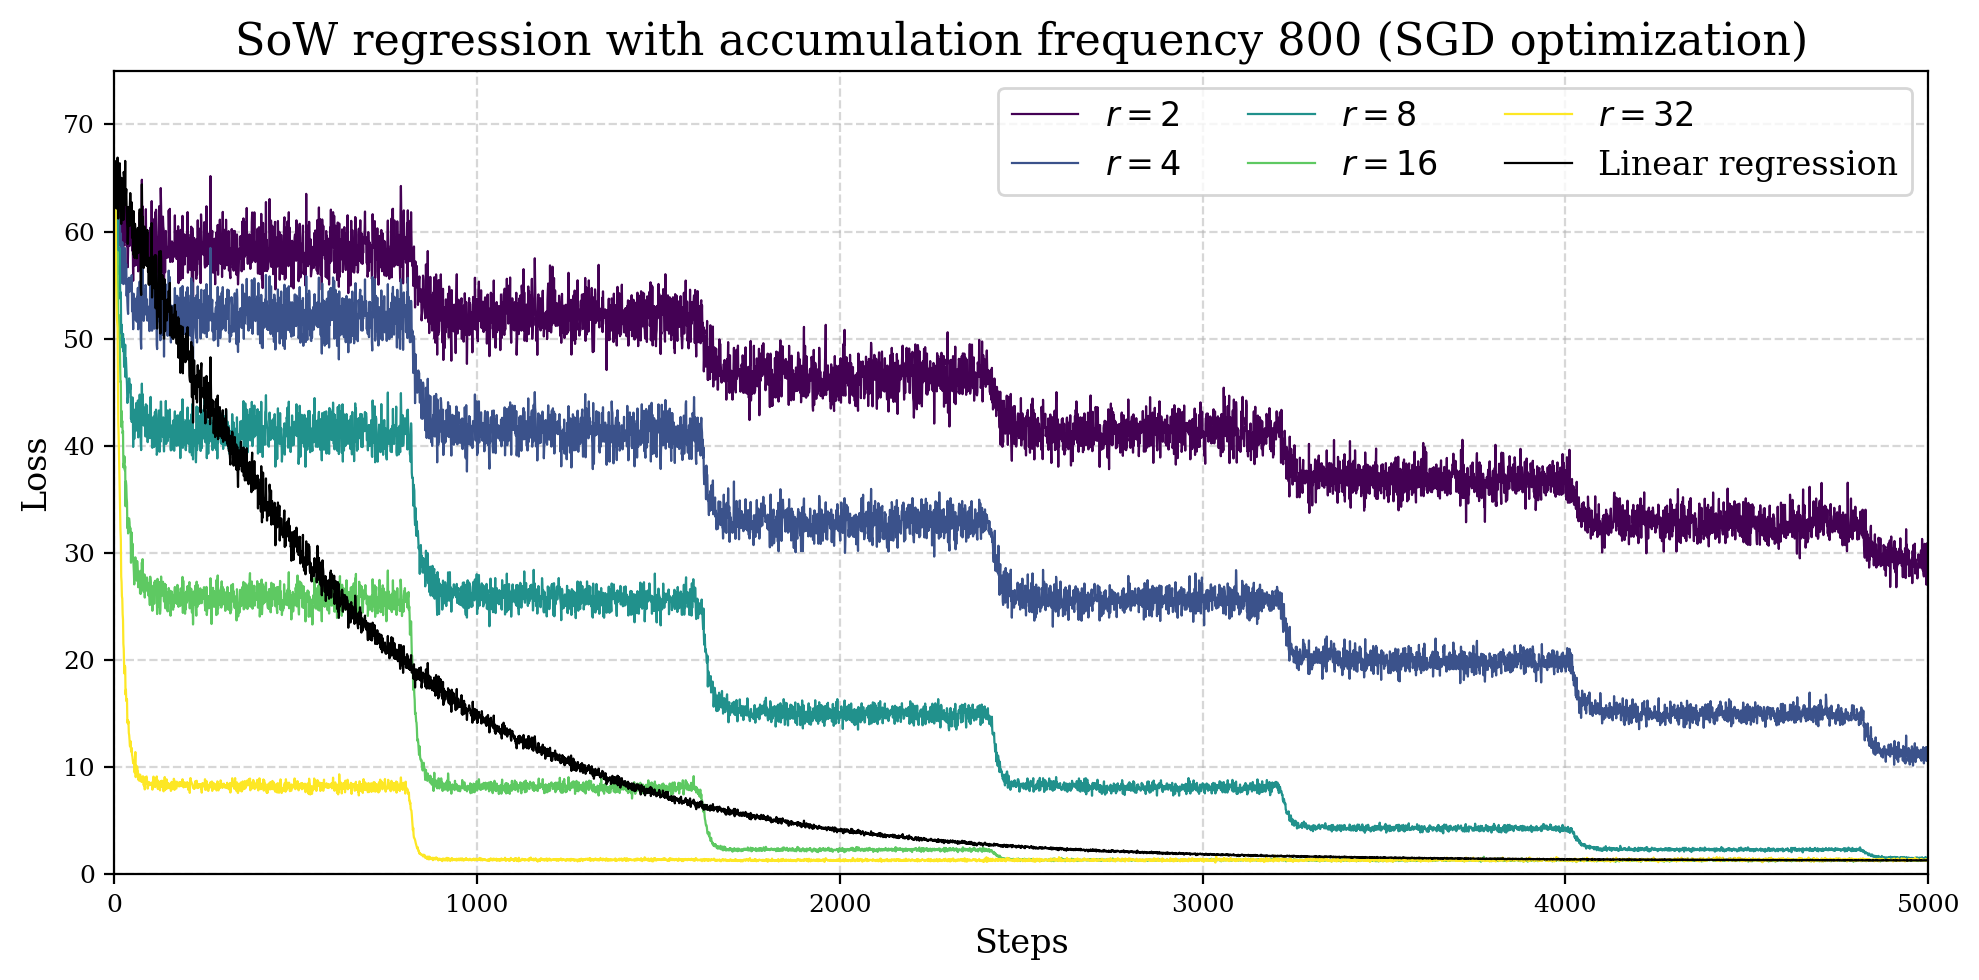

In [12]:
def plot_losses(losses, losses_sow, accumulation_steps):
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['font.family'] = 'serif'
    
    # For each accumulation step create a new subplot
    # fig, axes = plt.subplots(len(accumulation_steps), 1, figsize=(10, 10))
    # if len(accumulation_steps) == 1:
    #     axes = [axes]



    palette = plt.get_cmap('viridis', len(dict_models.keys()) // len(accumulation_steps))
    xlims = [1500, 1500, 5000, 5000]
    for idx, acc_steps in enumerate(accumulation_steps):
        fig = plt.figure(figsize=(10, 5))
        axis = fig.add_subplot(111)
        i = 0
        for key in dict_models.keys():
            if key[2] == acc_steps:
                # axes[idx]
                axis.plot(losses_sow[key], label=f"$r={key[0]}$", lw=0.8, color=palette(i))
                i += 1
        # axes[idx]
        axis.plot(losses, label="Linear regression", lw=0.8, color='black', linestyle='-')
        # axes[idx]
        axis.set_xlim(0, xlims[idx])
        # axes[idx]
        axis.set_ylim(0, 75)
        # axes[idx]
        axis.set_xlabel("Steps", fontsize=12)
        # axes[idx]
        axis.set_ylabel("Loss", fontsize=12)
        # axes[idx]
        axis.set_title(f"SoW regression with accumulation frequency {acc_steps} (SGD optimization)", fontsize=16)
        # axes[idx]
        axis.legend(fontsize=12, loc='upper right', ncol=3)
        # axes[idx]
        axis.grid(True, linestyle='--', alpha=0.5)
        # axes[idx]
        axis.tick_params(axis='both', which='major', labelsize=9)
        fig.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.savefig(f"sow_ref_{str(acc_steps)}.pgf")
        plt.plot()

plot_losses(losses, losses_sow, accumulation_steps)
# plt.savefig('linear_regression_losses2.png', dpi=200, bbox_inches='tight', transparent=True)
# plt.tight_layout()
# plt.savefig("lwerr_xavier.pgf")

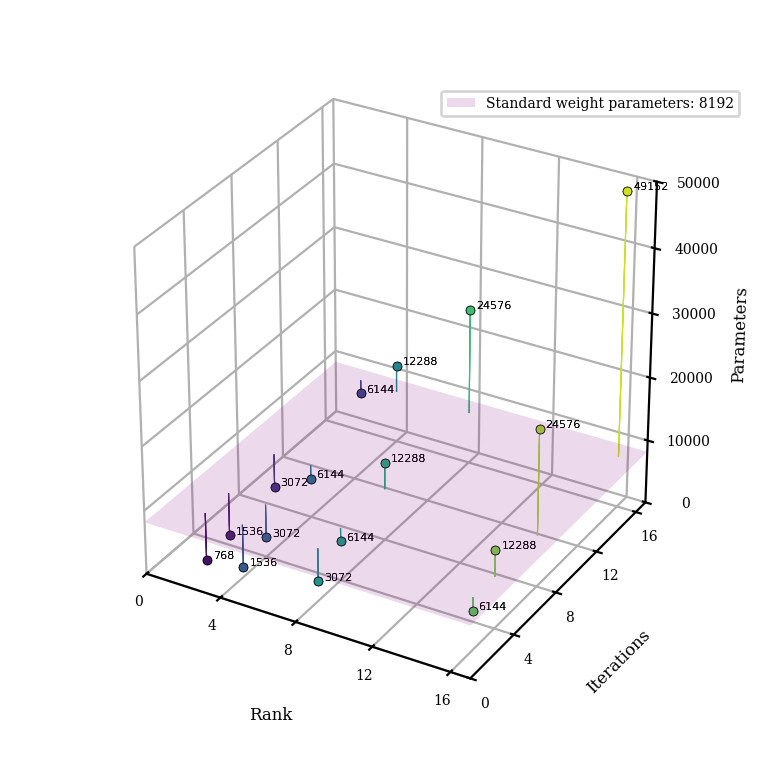

In [91]:
plt.rcParams['figure.dpi'] = 200
# Change font family for latex rendering
plt.rcParams['font.family'] = 'serif'

# 3D plot of surface rank, n_iter with z=n_iter*rank*(m+n)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ranks = np.linspace(1, 16, 16)
ranks = np.linspace(0, 17, 18)
n_iters = np.linspace(1, 16, 16)
n_iters = np.linspace(0, 17, 18)
rank_mesh, iter_mesh = np.meshgrid(ranks, n_iters)
n_params = rank_mesh * iter_mesh * (in_dim + out_dim)

# ax.plot_surface(rank_mesh, iter_mesh, n_params, alpha=0.5)
ax.plot_surface(rank_mesh, iter_mesh, in_dim*out_dim+rank_mesh*0+iter_mesh*0, alpha=0.15, shade=False, color="purple", linewidth=0.2, label=f"Standard weight parameters: {in_dim*out_dim}")
# , rstride=1, cstride=1, edgecolor='red'
# Add in_dim * out_dim as a reference
# Make it gridlike
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.zaxis.set_major_locator(plt.MaxNLocator(5))

palette = plt.get_cmap('viridis', len(dict_models.keys())+5)
for i, key in enumerate(dict_models.keys()):
    ax.scatter(
        key[0], key[1], key[0]*key[1]*(in_dim+out_dim), 
        # label=f"Acc steps: {key[2]}",
        marker='o', s=10, color=palette(i),
        alpha=1, edgecolors='black', linewidths=0.2
    )
    # Add vertical lines from the point to the n_params surface
    ax.plot(
        [key[0], key[0]], [key[1], key[1]], [key[0]*key[1]*(in_dim+out_dim), (in_dim*out_dim)],
        color=palette(i), linestyle='-',
        alpha=1.0, linewidth=0.4
    )
    # Add text to the points
    ax.text(key[0]+0.2, key[1]+0.2, key[0]*key[1]*(in_dim+out_dim)+40, key[0]*key[1]*(in_dim+out_dim), fontsize=4, color="black", fontweight='light', fontfamily='sans-serif')
ax.set_xlabel('Rank')

# ax.xaxis.set_tick_params(labelsize=7)
# ax.yaxis.set_tick_params(labelsize=7)
# ax.zaxis.set_tick_params(labelsize=7)
ax.xaxis.label.set_size(6)
ax.yaxis.label.set_size(6)
ax.zaxis.label.set_size(6)

# # Unpad axes
ax.get_xaxis().set_tick_params(pad=-2)
ax.get_yaxis().set_tick_params(pad=-2)
# ax.get_zaxis().set_tick_params(pad=2)



# Remove distortion
ax.set_box_aspect([1,1,1], zoom=0.85)
# Set background color to transparent
ax.patch.set_alpha(0)
# Remove background color
ax.patch.set_facecolor('none')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.set_xlim(0, 17)
ax.set_ylim(0, 17)
ax.set_zlim(0, 50000)

ax.tick_params(axis='both', which='major', labelsize=5)

ax.set_ylabel('Iterations')
ax.set_zlabel('Parameters')
ax.legend(fontsize=5, loc=(0.57, 0.87))
# ax.set_title('Number of parameters as a function of rank and iterations')
# plt.savefig('linear_regression_number_params.png', dpi=200, bbox_inches='tight', transparent=True)

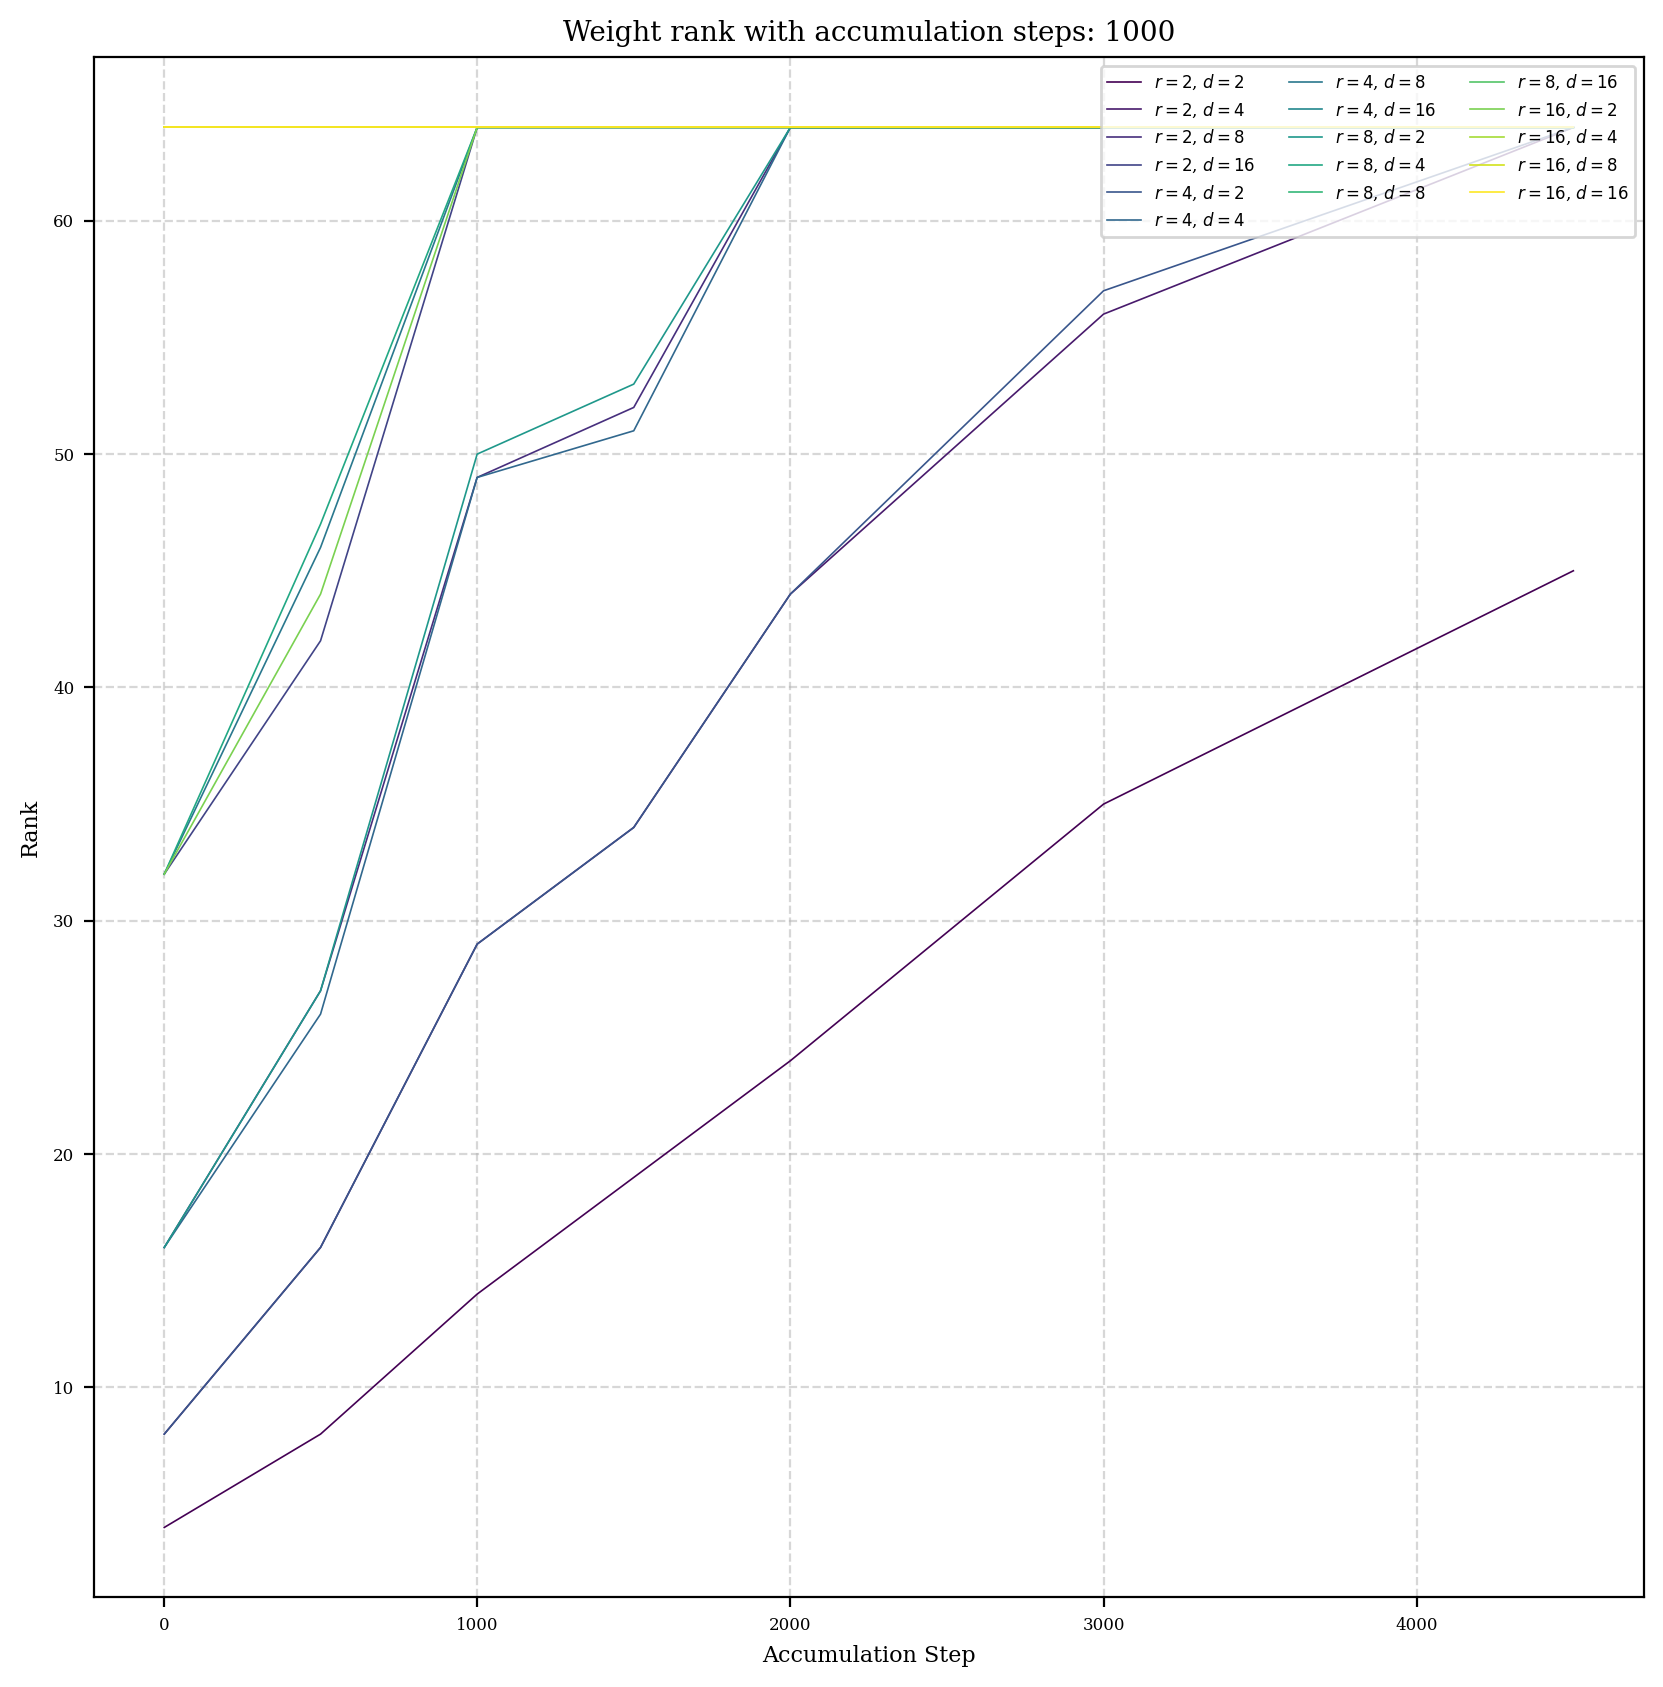

In [186]:
plt.rcParams['figure.dpi'] = 200

flash_steps = [1, 500, 1000, 1500, 2000, 3000, 4500, 5000]
fig, axes = plt.subplots(len(accumulation_steps), 1, figsize=(10, 10))
if len(accumulation_steps) == 1:
    axes = [axes]
palette = plt.get_cmap('viridis', len(dict_models.keys()) // len(accumulation_steps))

for idx, acc_steps in enumerate(accumulation_steps):
    i = 0
    for key in dict_models.keys():
        if key[2] == acc_steps:
            axes[idx].plot(flash_steps[:len(weight_ranks[key])], weight_ranks[key], label=f"$r={key[0]}$, $d={key[1]}$", lw=0.6, color=palette(i))
            i += 1
    axes[idx].set_xlabel("Accumulation Step", fontsize=8)
    axes[idx].set_ylabel("Rank", fontsize=8)
    axes[idx].set_title(f"Weight rank with accumulation steps: {acc_steps}", fontsize=10)
    axes[idx].legend(fontsize=6, loc='upper right', ncol=3)
    axes[idx].grid(True, linestyle='--', alpha=0.5)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
    fig.subplots_adjust(hspace=0.5)

# plt.savefig('linear_regression_weight_ranks.png', dpi=200, bbox_inches='tight', transparent=True)

KeyError: (2, 2, 1000)

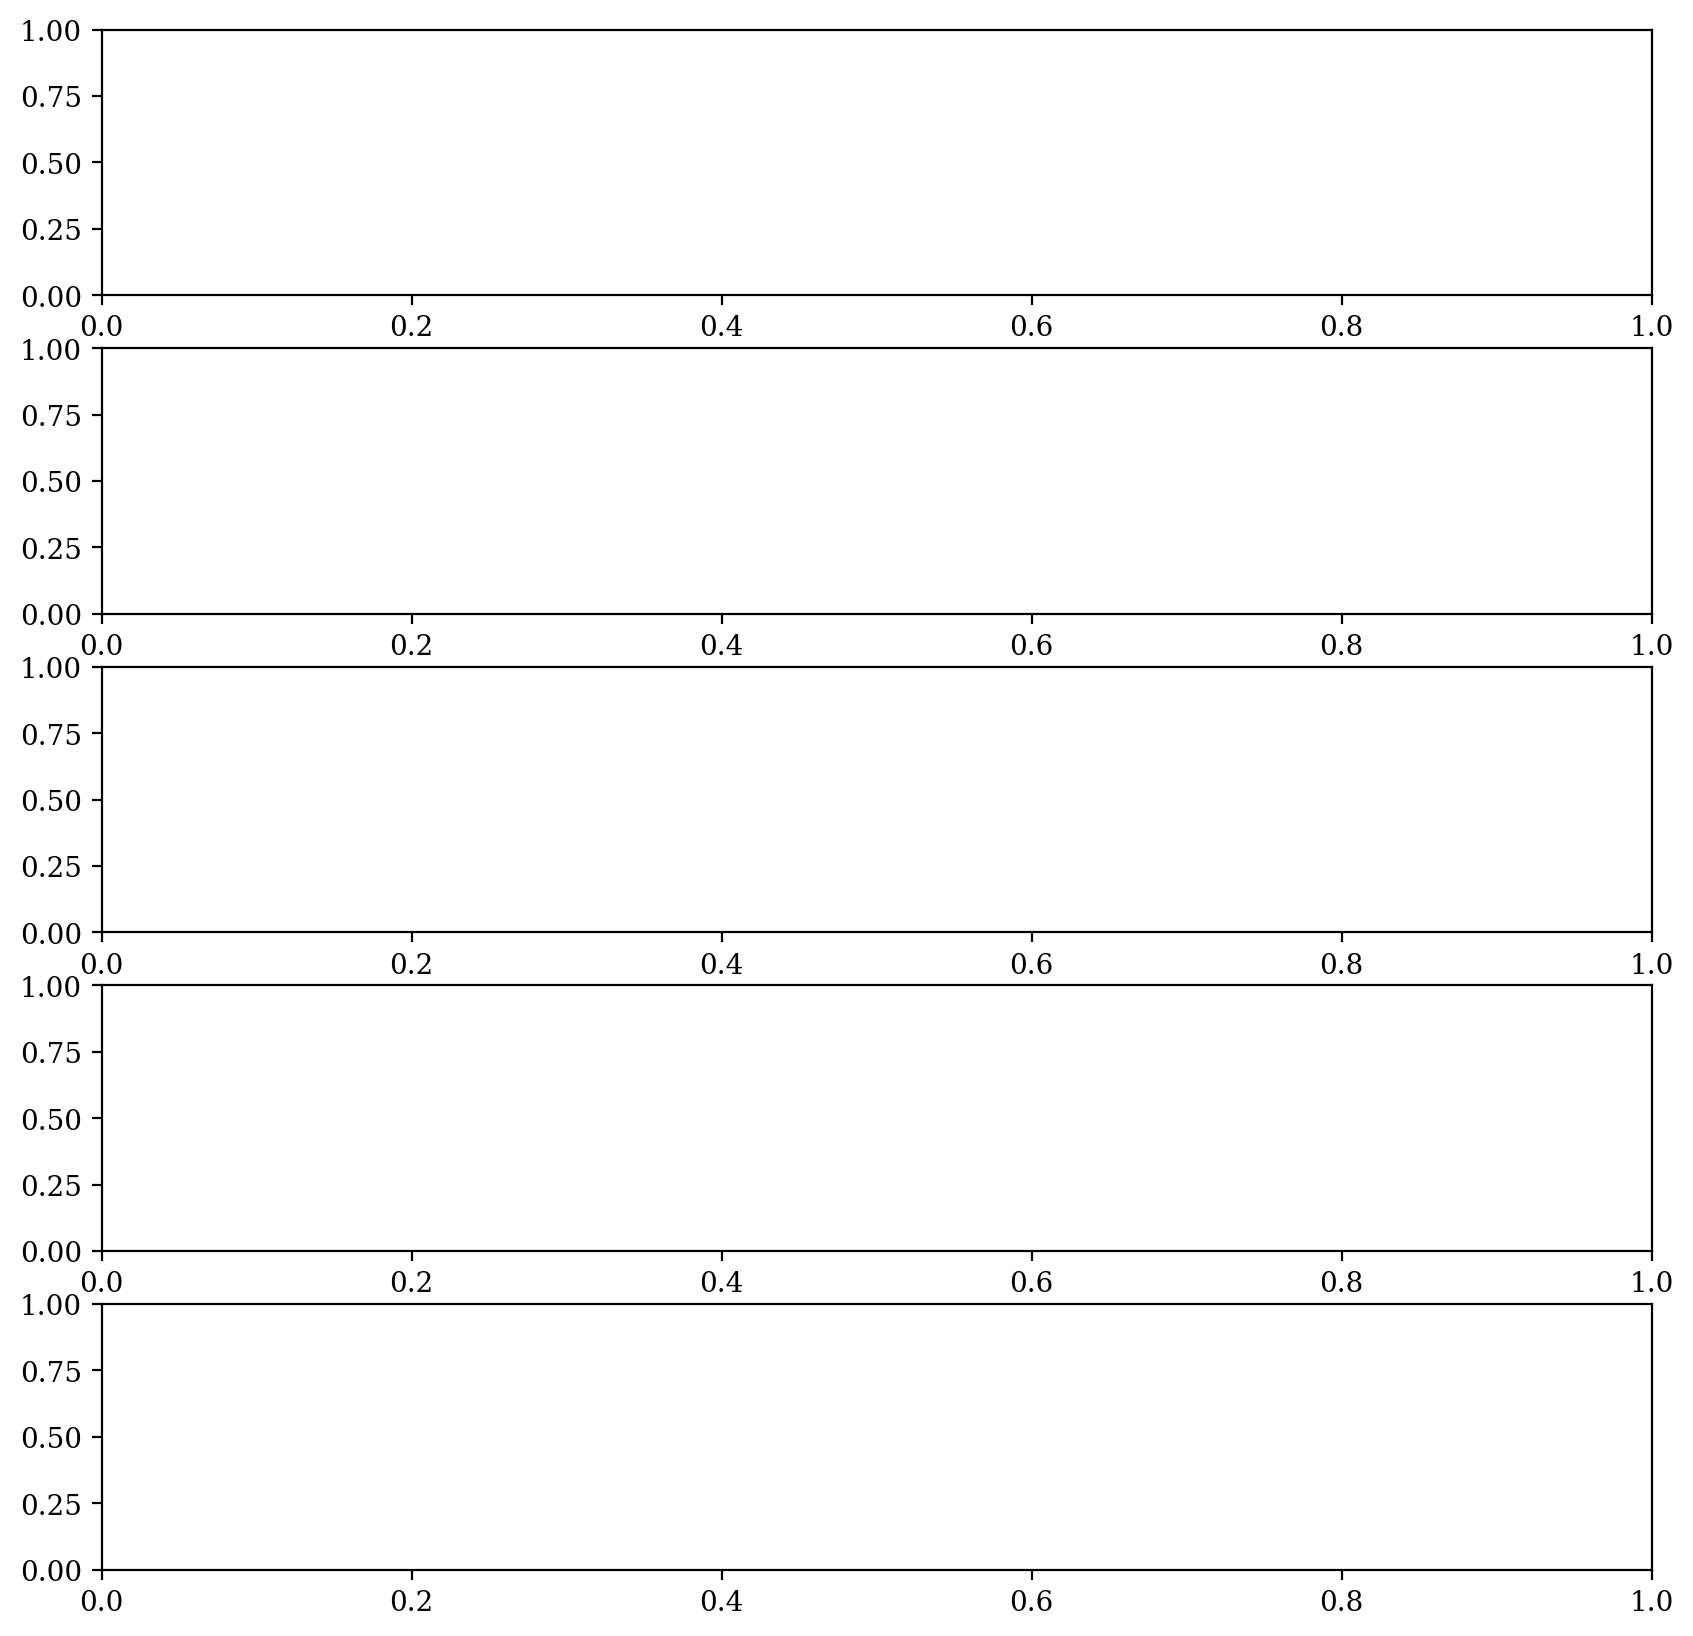

In [ ]:
plt.rcParams['figure.dpi'] = 200

# n_configs = 4
# random_idx = np.random.randint(0, len(dict_models.keys()), n_configs)
# random_configs = [list(dict_models.keys())[idx] for idx in random_idx]
# random_configs = [(2, 2, 50), (2, 4, 100), (2, 8, 400), (4, 2, 400)]
# random_configs = [(2, 2, 1000), (2, 4, 1000), (2, 8, 1000), (4, 2, 1000)]
# random_configs = [(2, 2, 1000), (2, 4, 1000), (2, 8, 1000), (4, 2, 1000)]
n_configs = len(random_configs)

fig, axes = plt.subplots(n_configs+1, 1, figsize=(10, 10))
palette2 = plt.get_cmap('plasma', n_configs)

for idx, conf in enumerate(random_configs):
    rank, n_iter, acc_steps = conf

    sv = [s.cpu().detach().numpy() for s in singular_values_sow[conf]]
    palette = plt.get_cmap('viridis', len(sv))

    for j in range(len(sv)):
        axes[idx].plot(sv[j], color=palette(j), lw=0.9, label=f'Step {flash_steps[j]}')

    for j in range(1, min(in_dim, out_dim) // (rank*n_iter) + 1):
        axes[idx].axvline(x=rank*n_iter*j, color='red', lw=0.5, linestyle='--', label="Accumulation" if j == 1 else None)
    axes[idx].plot(S.cpu().detach().numpy(), color='black', lw=0.4, label='Standard', linestyle='--')
    axes[idx].legend(fontsize=6, loc='upper right', ncol=3)
    axes[idx].set_xlabel("Singular value index", fontsize=8)
    axes[idx].set_ylabel("Singular value", fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=6)
    axes[idx].set_title(f"Singular values with rank={rank}, n_iter={n_iter}, acc_steps={acc_steps}", fontsize=10)
    fig.subplots_adjust(hspace=0.8)

palette = plt.get_cmap('viridis', len(singular_values))
for i, sv in enumerate(singular_values):
    axes[n_configs].plot(sv.cpu().detach().numpy(), label=f'Step {flash_steps[i]}', lw=0.6, color=palette(i))
axes[n_configs].plot(S.cpu().detach().numpy(), color='black', lw=0.4, label='Standard', linestyle='--')
axes[n_configs].legend(fontsize=6, loc='upper right', ncol=3)
# Change tick font size
axes[n_configs].tick_params(axis='both', which='major', labelsize=6)
axes[n_configs].set_xlabel("Singular value index", fontsize=8)
axes[n_configs].set_ylabel("Singular value", fontsize=8)
axes[n_configs].set_title("Singular values with standard linear regression", fontsize=10)

# plt.savefig('linear_regression_singular_values.png', dpi=200, bbox_inches='tight', transparent=True)

### Binary Classification

In [189]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, n_input_features, n_output_features):
        super(BinaryClassificationModel, self).__init__()
        self.linear = nn.Linear(n_input_features, n_output_features)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n_output_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.output(self.relu(self.linear(x))))
    
class SoWBinaryClassificationModel(nn.Module):
    def __init__(self, n_input_features, n_output_features, rank, n_iter, accumulation_steps=100):
        super(SoWBinaryClassificationModel, self).__init__()
        self.linear = SoWLinear(
            n_input_features, n_output_features,
            rank=rank, n_iter=n_iter, accumulation_steps=accumulation_steps,
            buffer_proj=False
        )
        self.relu = nn.ReLU()
        self.output = nn.Linear(n_output_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.output(self.relu(self.linear(x))))

In [218]:
in_dim = 128
out_dim = 64
batch_size = 64
n_samples = 100000

ground_model = BinaryClassificationModel(in_dim, out_dim).to('cuda')
ground_model.eval()

_, S, _ = torch.linalg.svd(ground_model.linear.weight)

x_trains = torch.tensor(np.random.randn(n_samples, in_dim), dtype=torch.float32).to('cuda')
y_trains = ground_model(x_trains).detach().to('cuda')
y_trains = (y_trains > 0.5).float()

learning_rate = 0.0005
ranks = [2, 4, 8]
n_iters = [2, 4, 8]
accumulation_steps = [50, 400, 800] #[50, 100, 400, 800]

dict_models = {}
dict_optimizers = {}

singular_values_sow = {}
numel_sow = {}

weight_ranks = {}

losses = []
accuracy = []
losses_sow = {}
accuracy_sow = {}

model = BinaryClassificationModel(in_dim, out_dim).to('cuda')

from itertools import product
for rank, n_iter, acc_steps in product(ranks, n_iters, accumulation_steps):
    model_sow = SoWBinaryClassificationModel(in_dim, out_dim, rank=rank, n_iter=n_iter, accumulation_steps=acc_steps).to('cuda')
    optimizer = optim.Adam(model_sow.parameters(), lr=learning_rate)
    dict_models[(rank, n_iter, acc_steps)] = model_sow
    dict_optimizers[(rank, n_iter, acc_steps)] = optimizer
    losses_sow[(rank, n_iter, acc_steps)] = []
    singular_values_sow[(rank, n_iter, acc_steps)] = []
    numel_sow[(rank, n_iter, acc_steps)] = []
    weight_ranks[(rank, n_iter, acc_steps)] = []
    accuracy_sow[(rank, n_iter, acc_steps)] = []

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

singular_values = []
numel_lreg = []

In [219]:
num_epochs = 5000

flash_steps = [1, 500, 1000, 1500, 2000, 3000, 4500, 5000]
flash_idx = 0
flash_idx_sow = 0

print("Num epochs: ", num_epochs)
for epoch in range(num_epochs):
    rand_idx = np.random.randint(0, n_samples, batch_size)
    x_train, y_train = x_trains[rand_idx], y_trains[rand_idx]
    
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    accuracy.append(torch.sum((y_pred > 0.5) == y_train).item() / batch_size)
    
    if flash_idx < len(flash_steps):
        if epoch % flash_steps[flash_idx] == 0:
            weight = model.linear.weight.detach()
            _, S, _ = torch.linalg.svd(weight)
            singular_values.append(S)
            flash_idx += 1

    for key, model_sow in dict_models.items():
        optimizer_sow = dict_optimizers[key]
        y_pred_sow = model_sow(x_train)
        loss_sow = criterion(y_pred_sow, y_train)
        optimizer_sow.zero_grad()
        loss_sow.backward()
        project_grad(model_sow)

        optimizer_sow.step()
        losses_sow[key].append(loss_sow.item())
        accuracy_sow[key].append(torch.sum((y_pred_sow > 0.5) == y_train).item() / batch_size)

        if flash_idx_sow < len(flash_steps):
            if epoch % flash_steps[flash_idx_sow] == 0:
                weight = torch.sum(torch.stack([a.detach() @ b.detach() for a, b in zip(model_sow.linear.downscale_weights, model_sow.linear.upscale_weights)]), dim=0).detach()
                if model_sow.linear.accumulated_weight is not None:
                    weight += model_sow.linear.accumulated_weight

                _, S, _ = torch.linalg.svd(weight)
                singular_values_sow[key].append(S)

                numel_sow[key].append(numel_model(model_sow))
                weight_ranks[key].append(torch.sum(S > 1e-6).item())

    if flash_idx_sow < len(flash_steps):
        if epoch % flash_steps[flash_idx_sow] == 0:
            flash_idx_sow += 1

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss Standard: {loss.item():.4f}, Loss SoW: {loss_sow.item():.4f}',
              f'Accuracy Standard: {accuracy[-1]:.4f}, Accuracy SoW: {accuracy_sow[key][-1]:.4f}')


Num epochs:  5000
Epoch [100/5000], Loss Standard: 0.6827, Loss SoW: 0.7097 Accuracy Standard: 0.5938, Accuracy SoW: 0.5312
Epoch [200/5000], Loss Standard: 0.6401, Loss SoW: 0.6300 Accuracy Standard: 0.6719, Accuracy SoW: 0.6406
Epoch [300/5000], Loss Standard: 0.6392, Loss SoW: 0.6608 Accuracy Standard: 0.6562, Accuracy SoW: 0.5469
Epoch [400/5000], Loss Standard: 0.6270, Loss SoW: 0.6669 Accuracy Standard: 0.7500, Accuracy SoW: 0.6094
Epoch [500/5000], Loss Standard: 0.6007, Loss SoW: 0.5655 Accuracy Standard: 0.7812, Accuracy SoW: 0.7500
Epoch [600/5000], Loss Standard: 0.5808, Loss SoW: 0.5638 Accuracy Standard: 0.8438, Accuracy SoW: 0.7188
Epoch [700/5000], Loss Standard: 0.6079, Loss SoW: 0.6072 Accuracy Standard: 0.6875, Accuracy SoW: 0.6406
Epoch [800/5000], Loss Standard: 0.5721, Loss SoW: 0.5176 Accuracy Standard: 0.7188, Accuracy SoW: 0.7812
Epoch [900/5000], Loss Standard: 0.5477, Loss SoW: 0.5437 Accuracy Standard: 0.7344, Accuracy SoW: 0.7500
Epoch [1000/5000], Loss Stan

In [212]:
save = True
if save:
    with open('binary_classification_models.pkl', 'wb') as f:
        pickle.dump(dict_models, f)
    with open('binary_classification_losses.pkl', 'wb') as f:
        pickle.dump(losses, f)
    with open('binary_classification_accuracy.pkl', 'wb') as f:
        pickle.dump(accuracy, f)
    with open('binary_classification_losses_sow.pkl', 'wb') as f:
        pickle.dump(losses_sow, f)
    with open('binary_classification_accuracy_sow.pkl', 'wb') as f:
        pickle.dump(accuracy_sow, f)
    with open('binary_classification_singular_values.pkl', 'wb') as f:
        pickle.dump(singular_values, f)
    with open('binary_classification_singular_values_sow.pkl', 'wb') as f:
        pickle.dump(singular_values_sow, f)
    with open('binary_classification_weight_ranks.pkl', 'wb') as f:
        pickle.dump(weight_ranks, f)

load = False
if load:
    with open('binary_classification_models.pkl', 'rb') as f:
        dict_models = pickle.load(f)
    with open('binary_classification_losses.pkl', 'rb') as f:
        losses = pickle.load(f)
    with open('binary_classification_accuracy.pkl', 'rb') as f:
        accuracy = pickle.load(f)
    with open('binary_classification_losses_sow.pkl', 'rb') as f:
        losses_sow = pickle.load(f)
    with open('binary_classification_accuracy_sow.pkl', 'rb') as f:
        accuracy_sow = pickle.load(f)
    with open('binary_classification_singular_values.pkl', 'rb') as f:
        singular_values = pickle.load(f)
    with open('binary_classification_singular_values_sow.pkl', 'rb') as f:
        singular_values_sow = pickle.load(f)

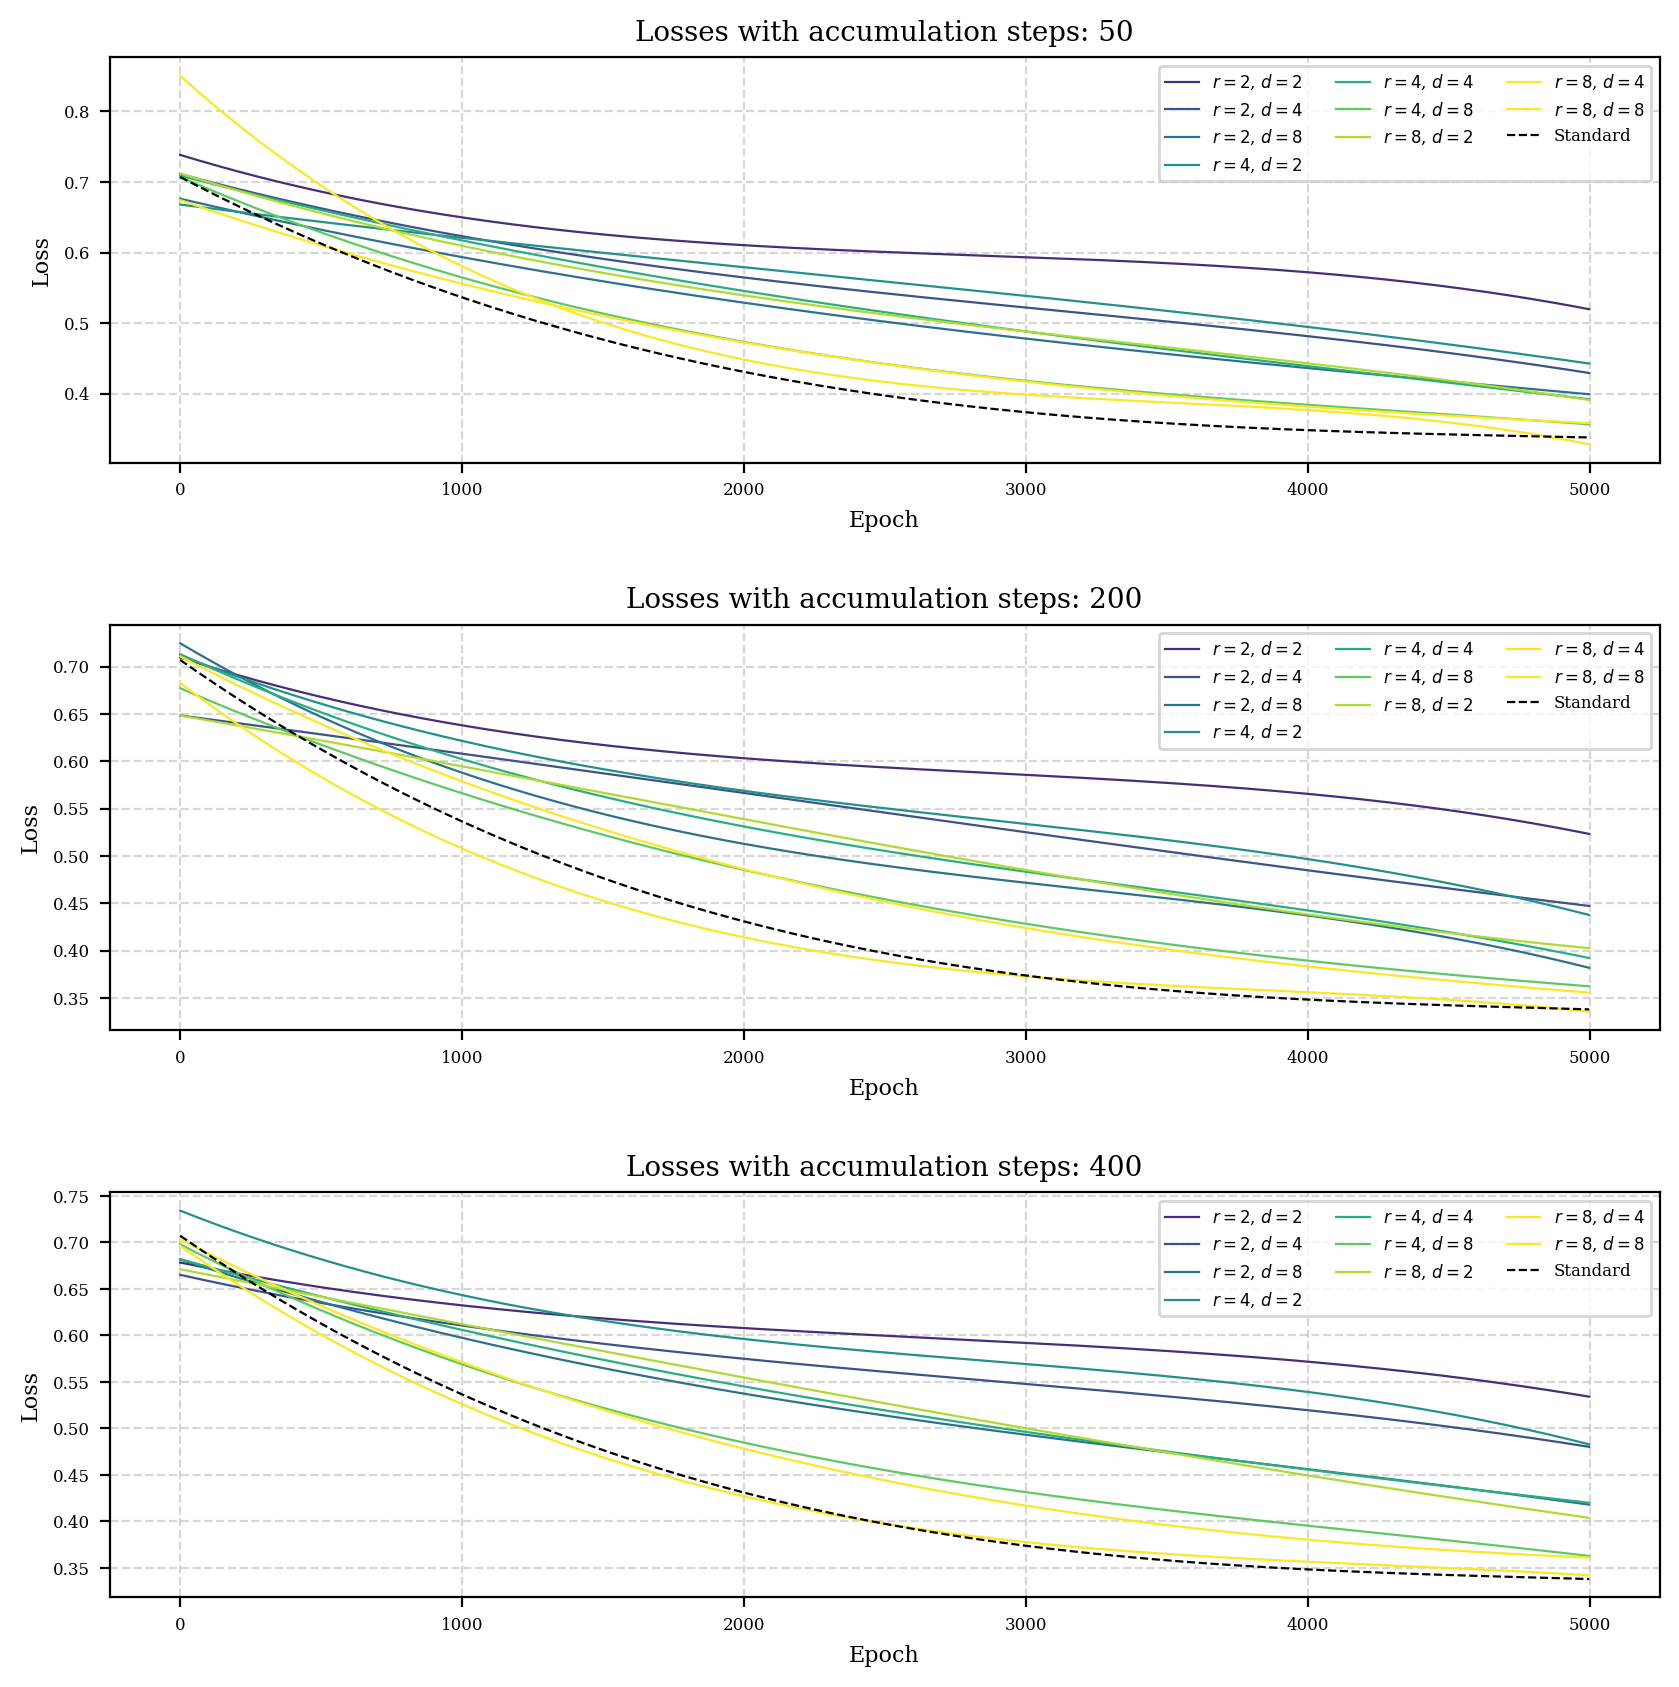

In [227]:
import numpy as np

def plot_losses(losses, losses_sow, accumulation_steps):
    plt.rcParams['figure.dpi'] = 200
    
    # For each accumulation step create a new subplot
    fig, axes = plt.subplots(len(accumulation_steps), 1, figsize=(10, 10))
    if len(accumulation_steps) == 1:
        axes = [axes]

    palette = plt.get_cmap('viridis', len(dict_models.keys()) // len(accumulation_steps))
    for idx, acc_steps in enumerate(accumulation_steps):
        i = 0
        for key in dict_models.keys():
            if key[2] == acc_steps:
                # axes[idx].plot(losses_sow[key], label=f"$r={key[0]}$, $d={key[1]}$", lw=0.4, color=palette(i))
                i += 1
                
                degree = 3
                coeffs = np.polyfit(range(len(losses_sow[key])), losses_sow[key], degree)
                y_poly = np.polyval(coeffs, range(len(losses_sow[key])))
                axes[idx].plot(y_poly, label=f"$r={key[0]}$, $d={key[1]}$", lw=0.8, color=palette(i), linestyle='-')
            
        degree = 3
        coeffs = np.polyfit(range(len(losses)), losses, degree)
        y_poly = np.polyval(coeffs, range(len(losses)))
        axes[idx].plot(y_poly, label=f"Standard", lw=0.8, color="black", linestyle='--')
        
        # axes[idx].plot(losses, label="Standard", lw=0.4, color='black', linestyle='-')
        # axes[idx].set_xlim(0, 2500)
        # axes[idx].set_ylim(0, 120)
        axes[idx].set_xlabel("Epoch", fontsize=8)
        axes[idx].set_ylabel("Loss", fontsize=8)
        axes[idx].set_title(f"Losses with accumulation steps: {acc_steps}", fontsize=10)
        axes[idx].legend(fontsize=6, loc='upper right', ncol=3)
        axes[idx].grid(True, linestyle='--', alpha=0.5)
        axes[idx].tick_params(axis='both', which='major', labelsize=6)
        fig.subplots_adjust(hspace=0.4)

plot_losses(losses, losses_sow, accumulation_steps)
# plt.savefig('linear_regression_losses2.png', dpi=200, bbox_inches='tight', transparent=True)

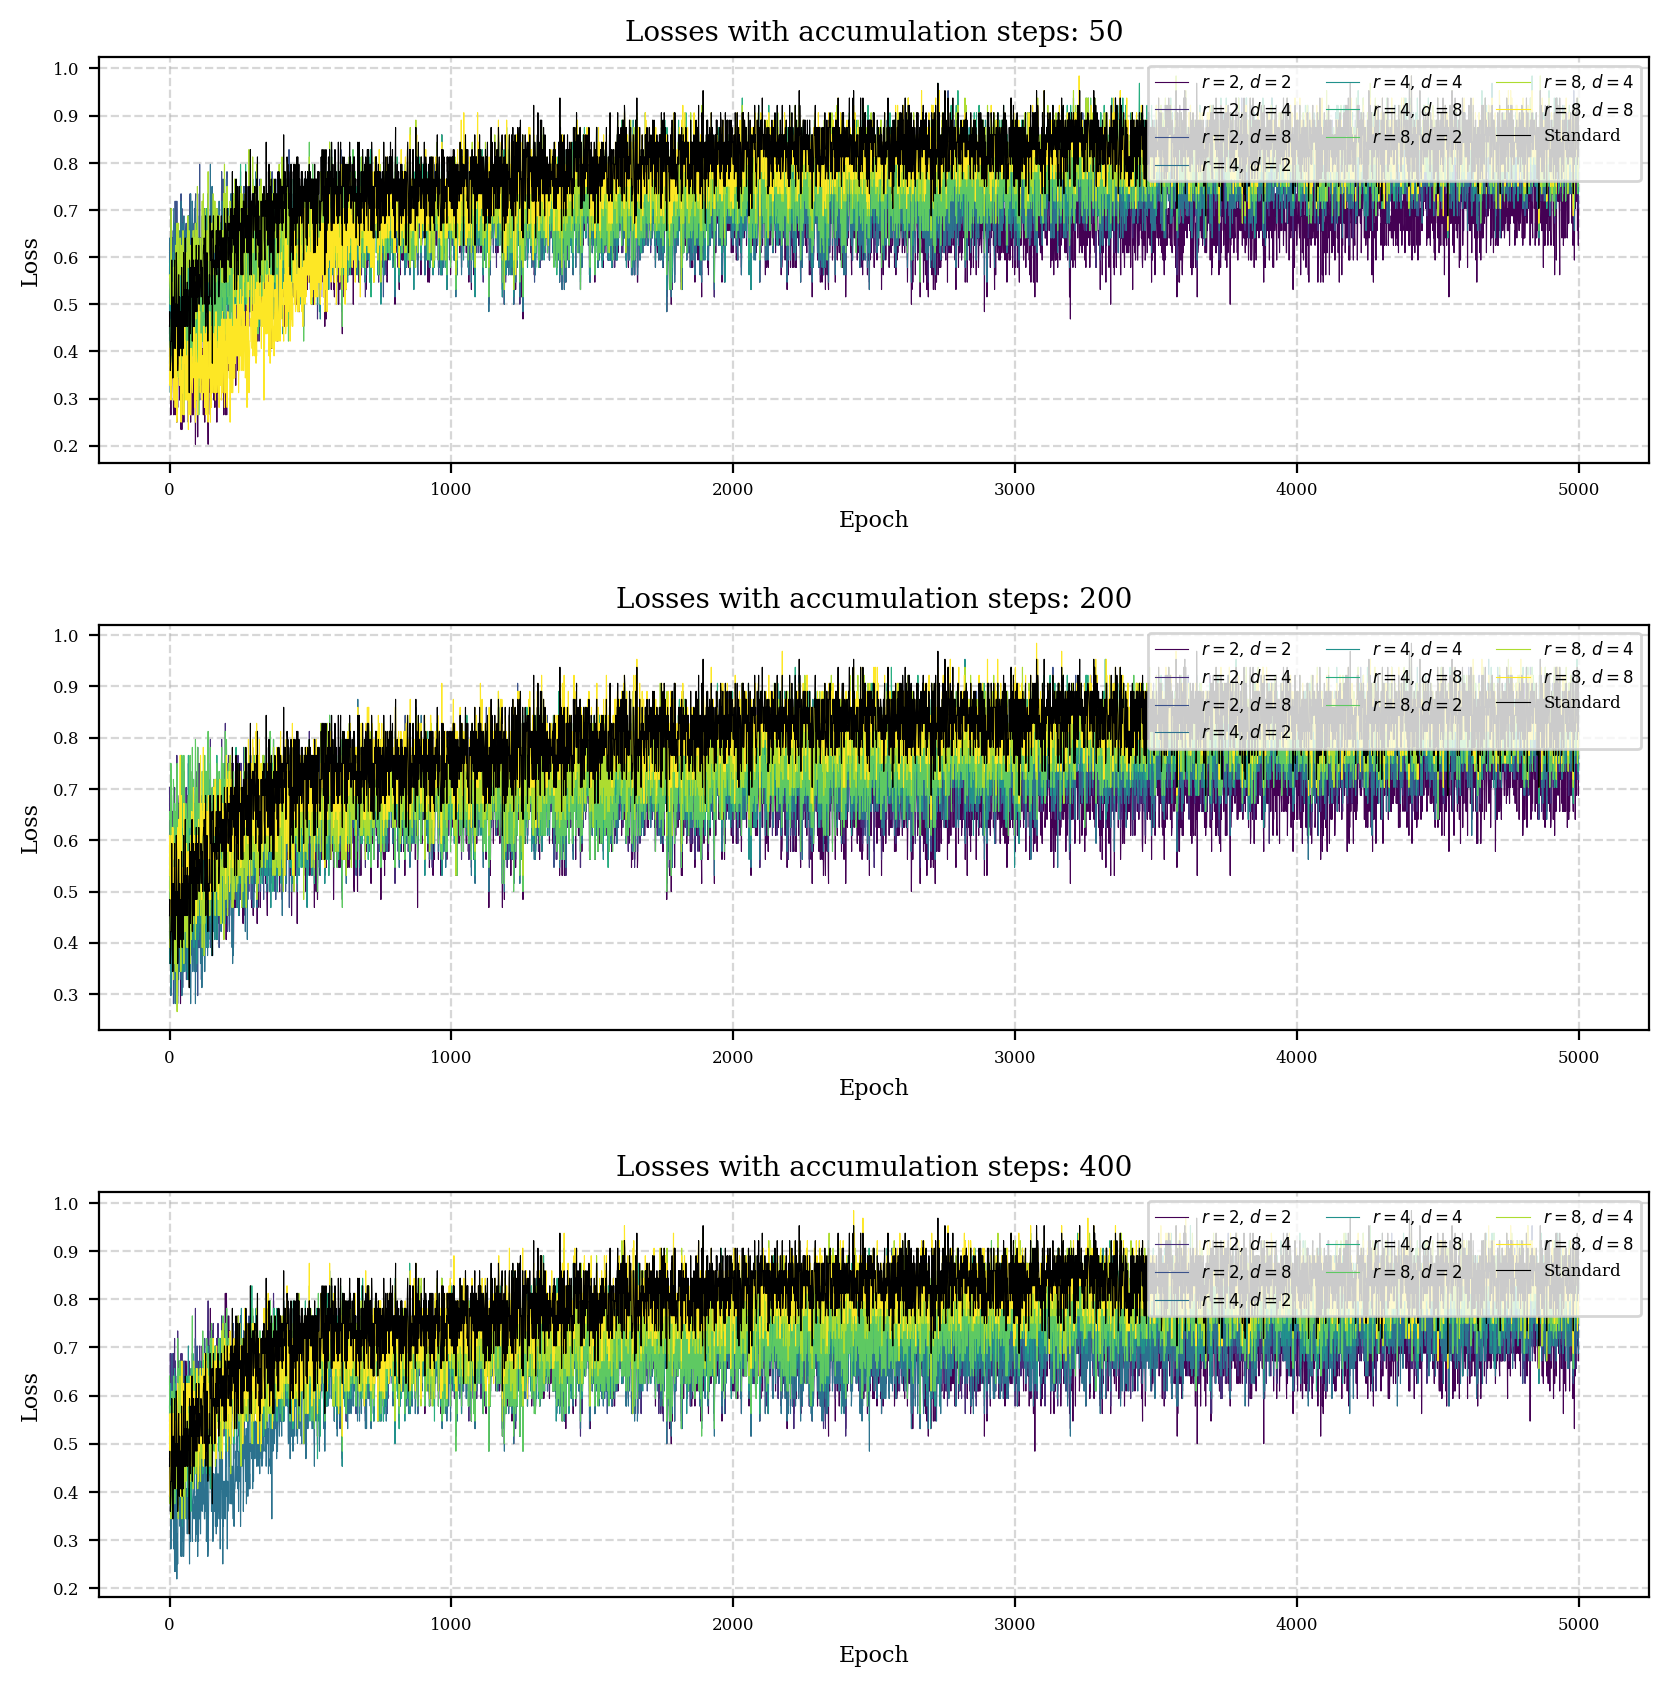

In [221]:
def plot_accuracies(accuracies, accuracies_sow, accumulation_steps):
    plt.rcParams['figure.dpi'] = 200
    
    # For each accumulation step create a new subplot
    fig, axes = plt.subplots(len(accumulation_steps), 1, figsize=(10, 10))
    if len(accumulation_steps) == 1:
        axes = [axes]

    palette = plt.get_cmap('viridis', len(dict_models.keys()) // len(accumulation_steps))
    for idx, acc_steps in enumerate(accumulation_steps):
        i = 0
        for key in dict_models.keys():
            if key[2] == acc_steps:
                axes[idx].plot(accuracies_sow[key], label=f"$r={key[0]}$, $d={key[1]}$", lw=0.4, color=palette(i))
                i += 1
        axes[idx].plot(accuracies, label="Standard", lw=0.4, color='black', linestyle='-')
        # axes[idx].set_xlim(0, 2500)
        # axes[idx].set_ylim(0, 120)
        axes[idx].set_xlabel("Epoch", fontsize=8)
        axes[idx].set_ylabel("Loss", fontsize=8)
        axes[idx].set_title(f"Losses with accumulation steps: {acc_steps}", fontsize=10)
        axes[idx].legend(fontsize=6, loc='upper right', ncol=3)
        axes[idx].grid(True, linestyle='--', alpha=0.5)
        axes[idx].tick_params(axis='both', which='major', labelsize=6)
        fig.subplots_adjust(hspace=0.4)

plot_losses(accuracy, accuracy_sow, accumulation_steps)
# plt.savefig('linear_regression_losses2.png', dpi=200, bbox_inches='tight', transparent=True)

[]

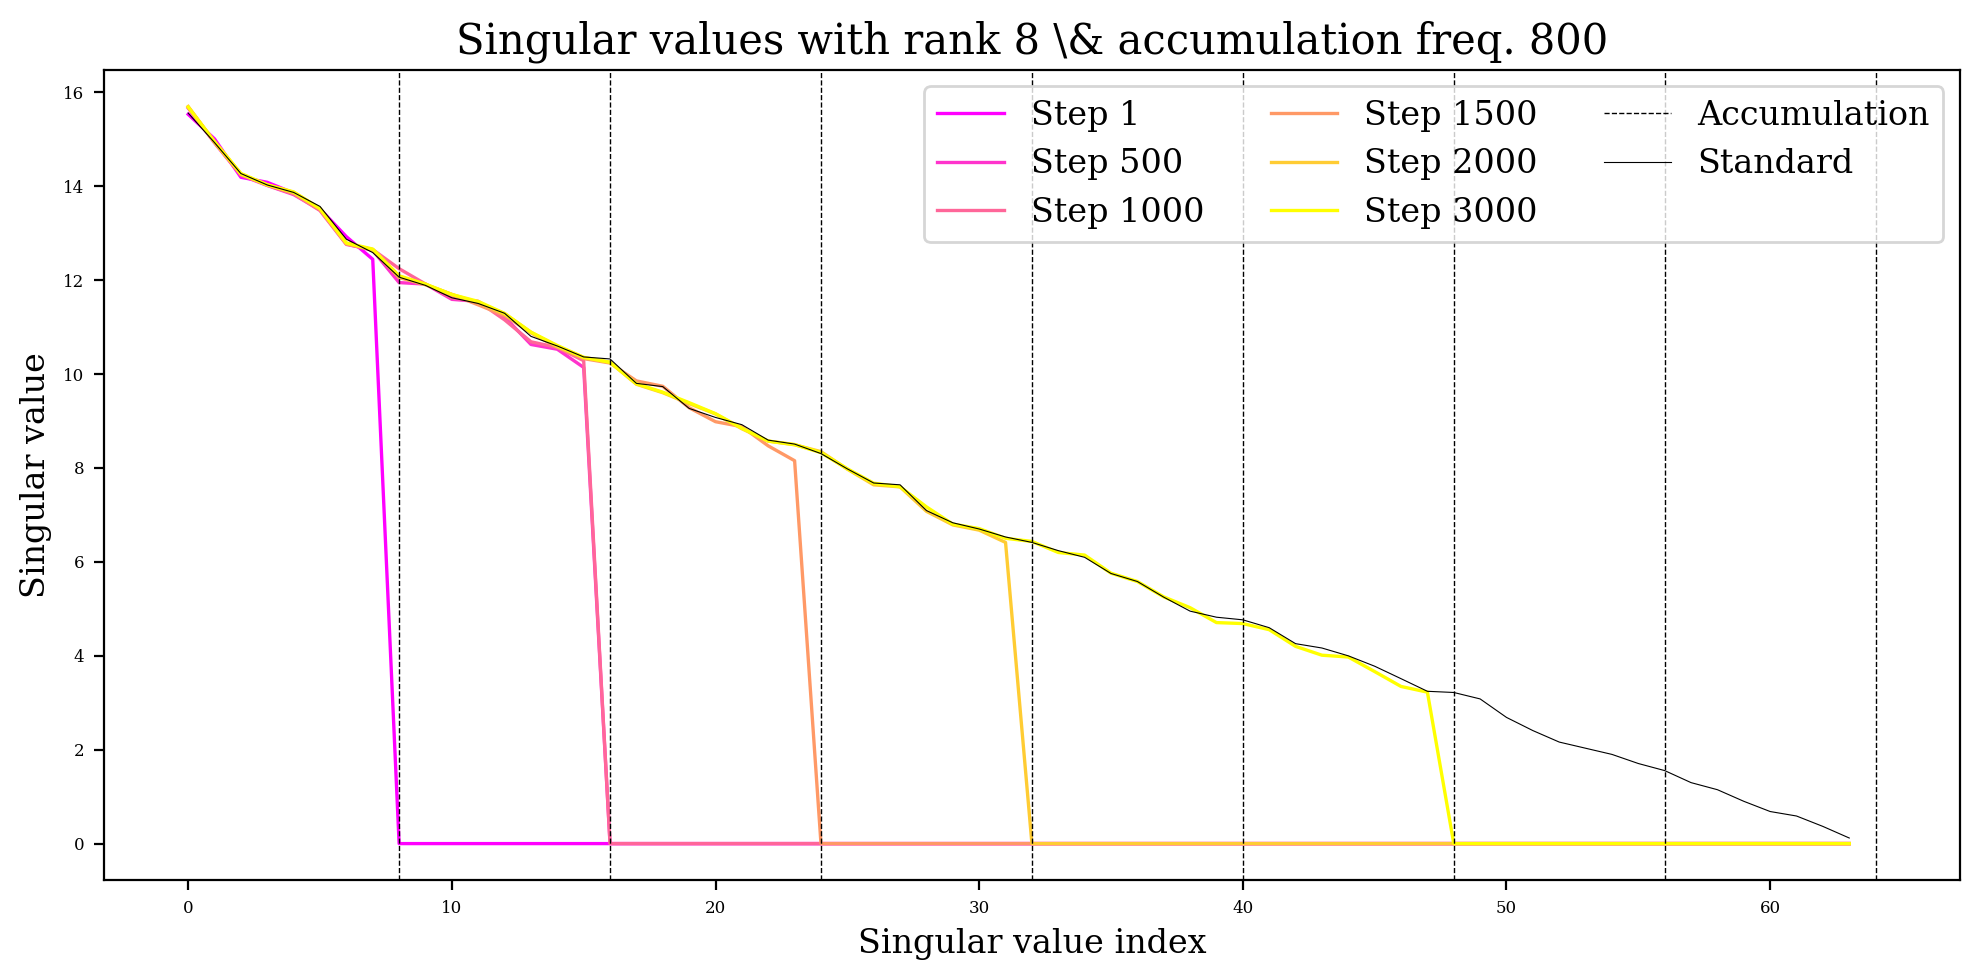

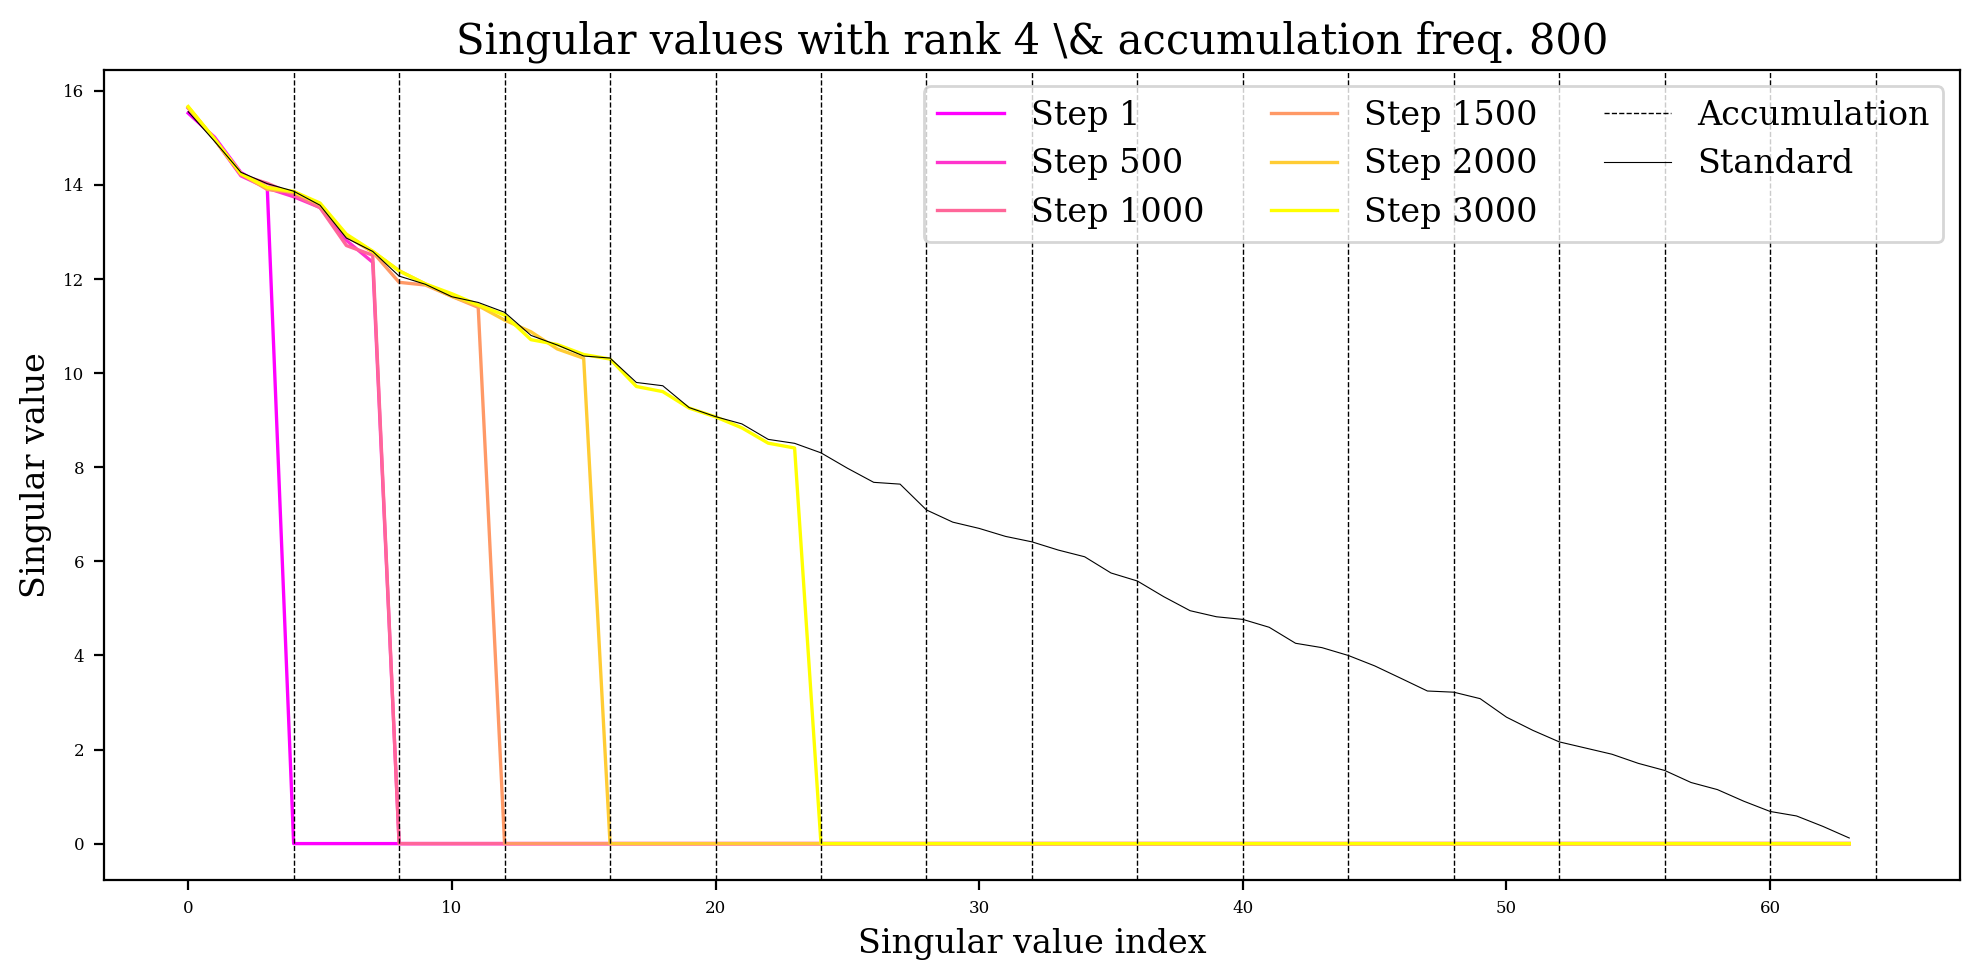

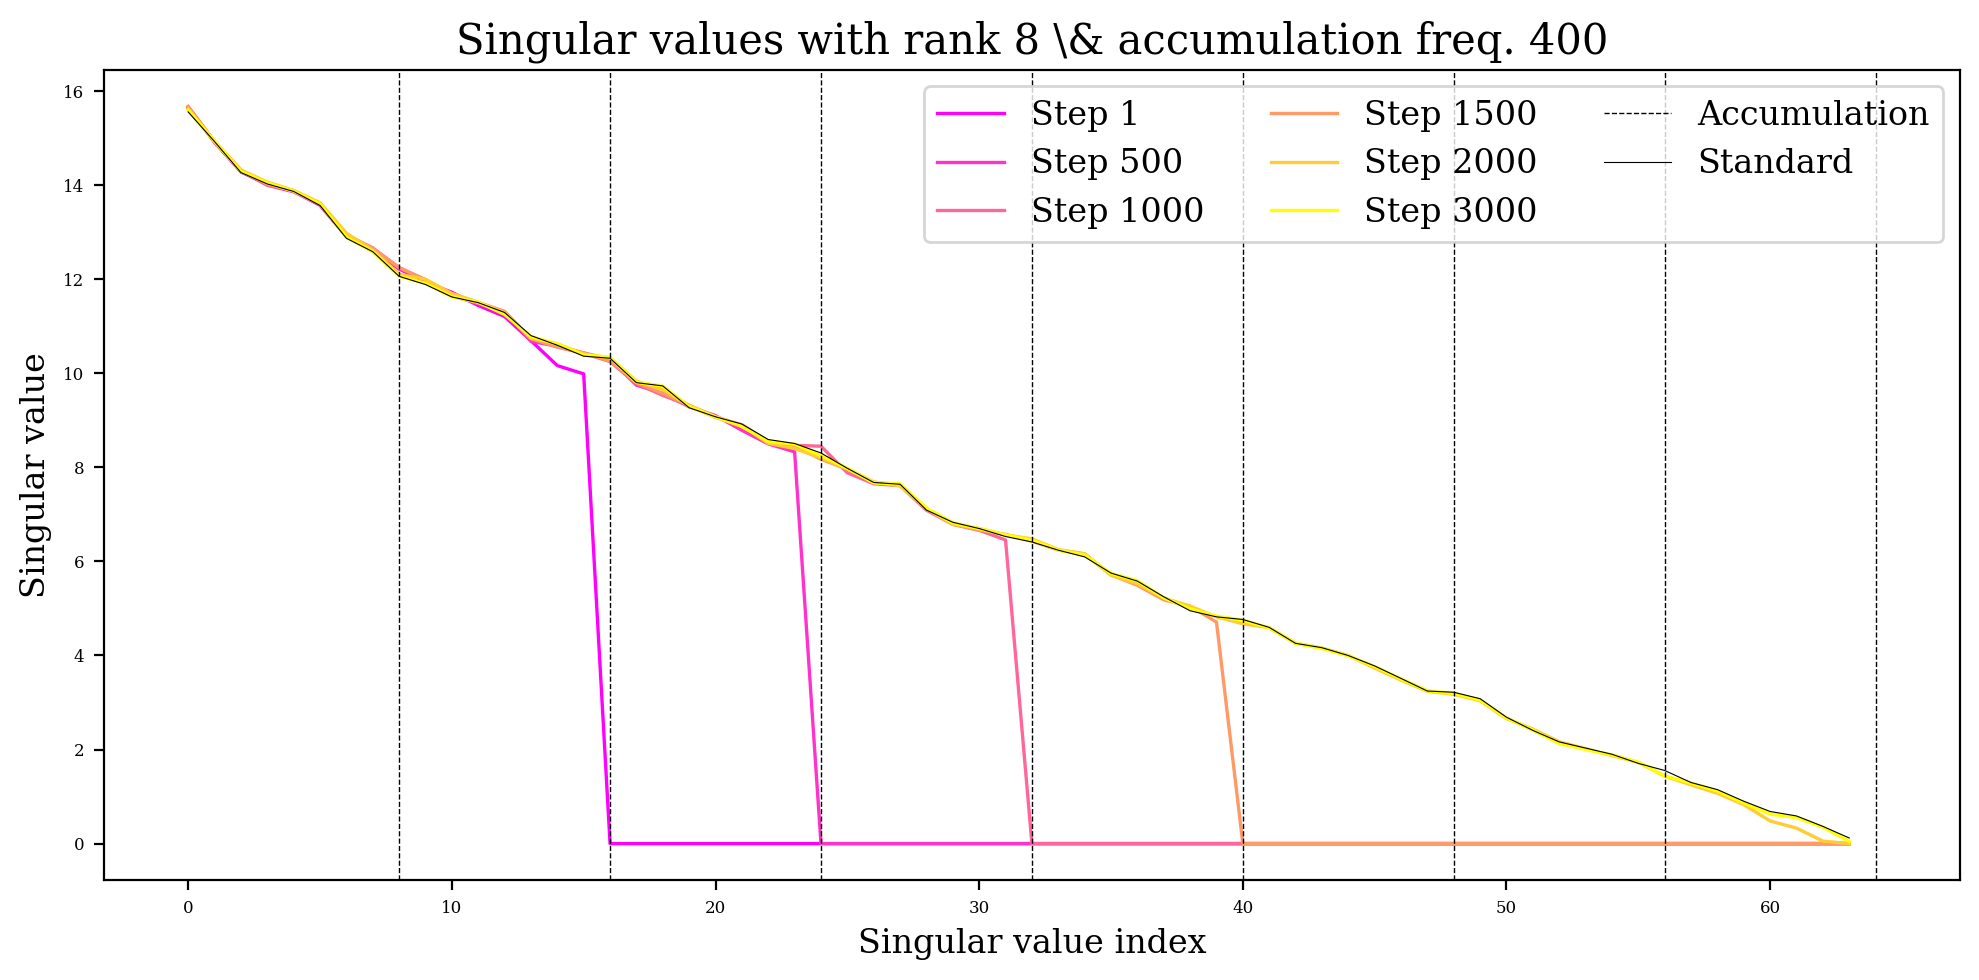

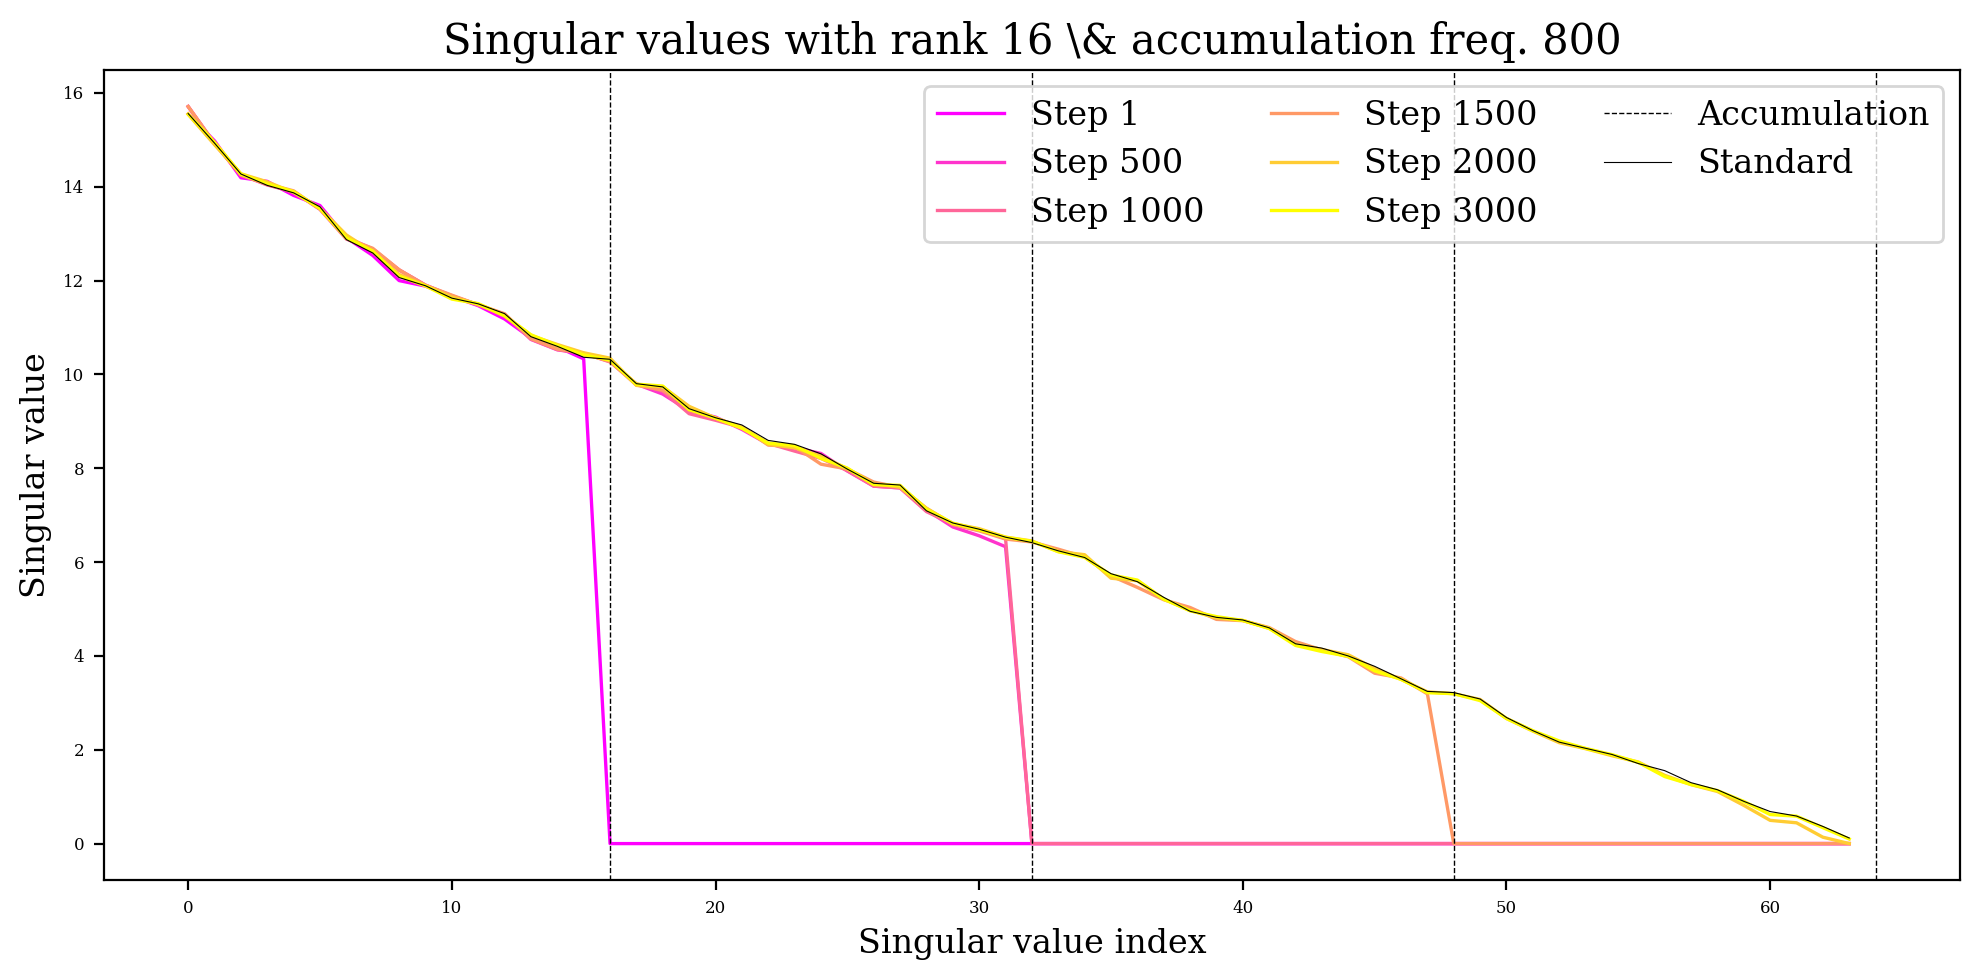

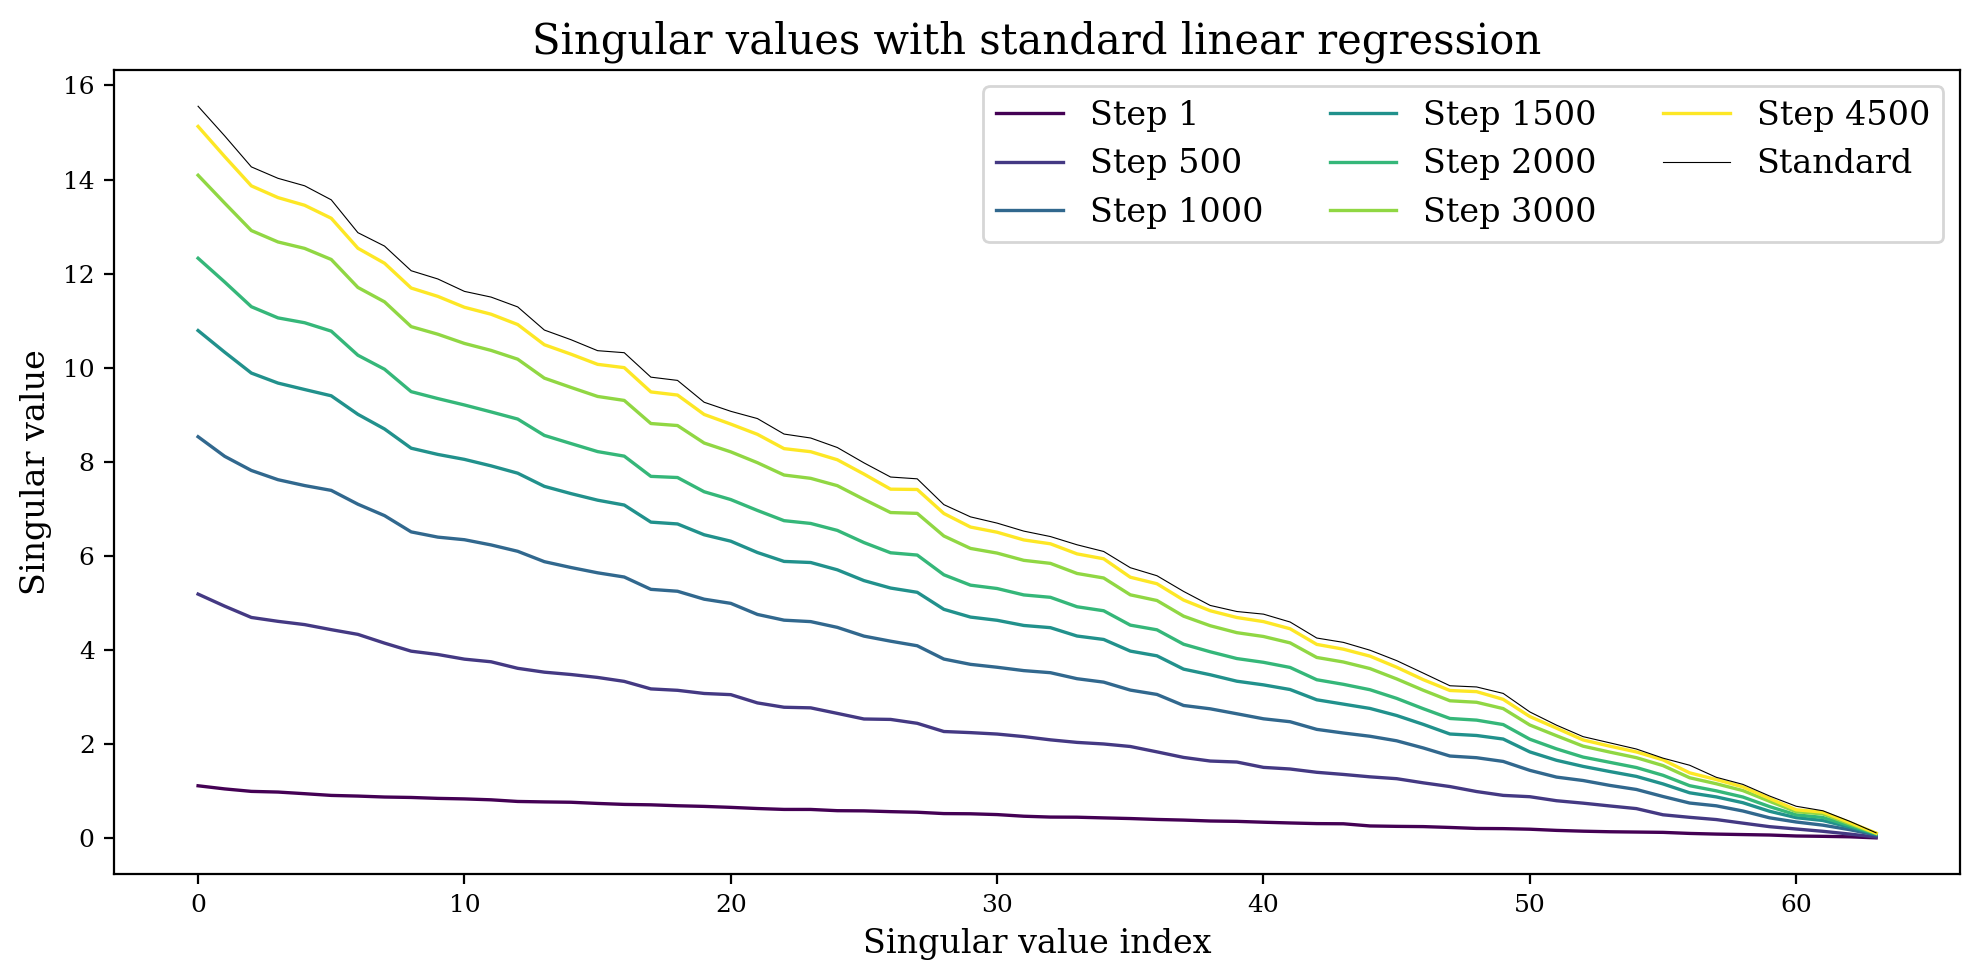

In [23]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'serif'

# n_configs = 4
# random_idx = np.random.randint(0, len(dict_models.keys()), n_configs)
# random_configs = [list(dict_models.keys())[idx] for idx in random_idx]
# random_configs = [(2, 2, 50), (2, 4, 100), (2, 8, 400), (4, 2, 400)]
# random_configs = [(8, 8, 400), (2, 4, 200), (2, 8, 400), (4, 2, 400)]
# ranks = [2, 4, 8, 16, 32]
# accumulation_steps = [50, 100, 400, 800]
random_configs = [(8, 1, 800), (4, 1, 800), (8, 1, 400), (16, 1, 800)]

n_configs = len(random_configs)

# fig, axes = plt.subplots(n_configs+1, 1, figsize=(10, 10))
palette = plt.get_cmap('plasma', n_configs)

for idx, conf in enumerate(random_configs):
    rank, n_iter, acc_steps = conf
    fig = plt.figure(figsize=(10, 5))
    axis = fig.add_subplot(111)

    sv = [s.cpu().detach().numpy() for s in singular_values_sow[conf]]
    palette = plt.get_cmap('spring', len(sv))

    for j in range(len(sv)):
        axis.plot(sv[j], color=palette(j), lw=1.2, label=f'Step {flash_steps[j]}')

    for j in range(1, min(in_dim, out_dim) // (rank*n_iter) + 1):
        axis.axvline(x=rank*n_iter*j, color='black', lw=0.5, linestyle='--', label="Accumulation" if j == 1 else None)
    axis.plot(S.cpu().detach().numpy(), color='black', lw=0.4, label='Standard', linestyle='-')
    axis.legend(fontsize=12, loc='upper right', ncol=3)
    axis.set_xlabel("Singular value index", fontsize=12)
    axis.set_ylabel("Singular value", fontsize=12)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_title(f"Singular values with rank {rank} \& accumulation freq. {acc_steps}", fontsize=15)
    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.savefig(f"sv_r_{str(rank)}_freq_{str(acc_steps)}.pgf")
    plt.plot()


fig = plt.figure(figsize=(10, 5))
axis = fig.add_subplot(111)
palette = plt.get_cmap('viridis', len(singular_values))
for i, sv in enumerate(singular_values):
    axis.plot(sv.cpu().detach().numpy(), label=f'Step {flash_steps[i]}', lw=1.2, color=palette(i))
axis.plot(S.cpu().detach().numpy(), color='black', lw=0.4, label='Standard', linestyle='-')
axis.legend(fontsize=12, loc='upper right', ncol=3)
# Change tick font size
axis.tick_params(axis='both', which='major', labelsize=9)
axis.set_xlabel("Singular value index", fontsize=12)
axis.set_ylabel("Singular value", fontsize=12)
axis.set_title("Singular values with standard linear regression", fontsize=15)
plt.tight_layout()
plt.savefig(f"sv_normal.pgf")
plt.plot()

# plt.savefig('linear_regression_singular_values.png', dpi=200, bbox_inches='tight', transparent=True)

### Multiple Linear layers

In [18]:
class MultiLinearRegressionModel(nn.Module):
    def __init__(self, feature_list):
        super(MultiLinearRegressionModel, self).__init__()
        # self.linears = nn.ModuleList([nn.Linear(feature_list[i], feature_list[i+1]) for i in range(len(feature_list) - 1)])
        # Add nn.ReLU() after each linear layer
        self.linears = nn.ModuleList([nn.Sequential(nn.Linear(feature_list[i], feature_list[i+1]), nn.ReLU()) for i in range(len(feature_list) - 2)] + [nn.Linear(feature_list[-2], feature_list[-1])])

    def forward(self, x):
        for linear in self.linears:
            x = linear(x)
        return x

class MultiSoWLinearRegressionModel(nn.Module):
    def __init__(self, feature_list, rank, n_iter, accumulation_steps=100):
        super(MultiSoWLinearRegressionModel, self).__init__()
        # self.linears = nn.ModuleList([SoWLinear(feature_list[i], feature_list[i+1], rank=rank, n_iter=n_iter, accumulation_steps=accumulation_steps) for i in range(len(feature_list) - 1)])
        # Add nn.ReLU() after each linear layer
        self.linears = nn.ModuleList([nn.Sequential(SoWLinear(feature_list[i], feature_list[i+1], rank=rank, n_iter=n_iter, accumulation_steps=accumulation_steps), nn.ReLU()) for i in range(len(feature_list) - 2)] + [nn.Linear(feature_list[-2], feature_list[-1])])
                                     #[SoWLinear(feature_list[-2], feature_list[-1], rank=rank, n_iter=n_iter, accumulation_steps=accumulation_steps)])

    def forward(self, x):
        for linear in self.linears:
            x = linear(x)
        return x
    
from torch.optim.lr_scheduler import LambdaLR

from math import floor, sqrt
def lr_lambda(step, accumulation_step):
    return 1# - sqrt(step / accumulation_step) 

from functools import partial
def lr_lambda2(step, accumulation_step):
    return 1 + floor(step / accumulation_step) / 5

In [19]:
features = [128, 256, 256, 128, 64]

# ground_model = nn.Sequential(*[nn.Sequential(nn.Linear(features[i], features[i+1]), nn.ReLU()) for i in range(len(features) - 2)], nn.Linear(features[-2], features[-1])).to('cuda')
ground_model = MultiLinearRegressionModel(features).to('cuda')
# ground_model = MultiLinearRegressionModel([32, 256, 32]).to('cuda')
ground_model.eval()

n_samples = 100000
x_trains = torch.tensor(np.random.randn(n_samples, features[0]), dtype=torch.float32, requires_grad=False).to('cuda')
y_trains = ground_model(x_trains).detach().to('cuda')

learning_rate = 0.0005
learning_rate_sow = 0.0005
ranks = [5]
n_iters = [3, 10]
accumulation_steps = [25, 100, 300, 500, 900]

dict_models = {}
dict_optimizers = {}
dict_schedulers = {}

singular_values = []
singular_values_sow = {}
numel_sow = {}

weight_ranks = {}

losses = []
losses_sow = {}

model = MultiLinearRegressionModel(features).to('cuda')
model_optim = optim.Adam(model.parameters(), lr=learning_rate)
criteria = nn.MSELoss()

from itertools import product
for rank, n_iter, acc_steps in product(ranks, n_iters, accumulation_steps):
    model_sow = MultiSoWLinearRegressionModel(features, rank=rank, n_iter=n_iter, accumulation_steps=acc_steps).to('cuda')
    optimizer = optim.Adam(model_sow.parameters(), lr=learning_rate_sow)
    scheduler = LambdaLR(optimizer, lr_lambda=partial(lr_lambda, accumulation_step=acc_steps))
    dict_models[(rank, n_iter, acc_steps)] = model_sow
    dict_optimizers[(rank, n_iter, acc_steps)] = optimizer
    dict_schedulers[(rank, n_iter, acc_steps)] = scheduler
    losses_sow[(rank, n_iter, acc_steps)] = []
    singular_values_sow[(rank, n_iter, acc_steps)] = []
    numel_sow[(rank, n_iter, acc_steps)] = []
    weight_ranks[(rank, n_iter, acc_steps)] = []

print("Standard model parameters: ", numel_model(ground_model))
print("MultiLinearRegressionModel parameters: ", numel_model(model))

for rank, n_iter, acc_steps in product(ranks, n_iters, accumulation_steps):
    print("-"*50)
    print(f"Rank: {rank}, n_iter: {n_iter}, acc_steps: {acc_steps}")
    print("Number of parameters: ", numel_model(dict_models[(rank, n_iter, acc_steps)]))

Standard model parameters:  139968
MultiLinearRegressionModel parameters:  139968
--------------------------------------------------
Rank: 5, n_iter: 3, acc_steps: 25
Number of parameters:  28096
--------------------------------------------------
Rank: 5, n_iter: 3, acc_steps: 100
Number of parameters:  28096
--------------------------------------------------
Rank: 5, n_iter: 3, acc_steps: 300
Number of parameters:  28096
--------------------------------------------------
Rank: 5, n_iter: 3, acc_steps: 500
Number of parameters:  28096
--------------------------------------------------
Rank: 5, n_iter: 3, acc_steps: 900
Number of parameters:  28096
--------------------------------------------------
Rank: 5, n_iter: 10, acc_steps: 25
Number of parameters:  72896
--------------------------------------------------
Rank: 5, n_iter: 10, acc_steps: 100
Number of parameters:  72896
--------------------------------------------------
Rank: 5, n_iter: 10, acc_steps: 300
Number of parameters:  728

In [20]:
num_epochs = 5000
batch_size = 64

flash_steps = [1, 500, 1000, 1500, 2000, 3000, 4500, 5000]
flash_idx = 0
flash_idx_sow = 0
layer_idx = 0

print("Num epochs: ", num_epochs)
for epoch in range(num_epochs):
    rand_idx = np.random.randint(0, n_samples, batch_size)
    x_train, y_train = x_trains[rand_idx], y_trains[rand_idx]
    
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    model_optim.zero_grad()
    loss.backward()
    model_optim.step()
    losses.append(loss.item())
    
    if flash_idx < len(flash_steps):
        if epoch % flash_steps[flash_idx] == 0:
            weight = model.linears[layer_idx][0].weight.detach()
            _, S, _ = torch.linalg.svd(weight)
            singular_values.append(S)
            flash_idx += 1

    for key, model_sow in dict_models.items():
        optimizer_sow = dict_optimizers[key]
        y_pred_sow = model_sow(x_train)
        loss_sow = criterion(y_pred_sow, y_train)
        optimizer_sow.zero_grad()
        loss_sow.backward()
        optimizer_sow.step()
        losses_sow[key].append(loss_sow.item())
        dict_schedulers[key].step()

        if flash_idx_sow < len(flash_steps):
            if epoch % flash_steps[flash_idx_sow] == 0:
                weight = torch.sum(torch.stack([a.detach() @ b.detach() for a, b in zip(model_sow.linears[layer_idx][0].downscale_weights, model_sow.linears[layer_idx][0].upscale_weights)]), dim=0).detach()
                if model_sow.linears[layer_idx][0].accumulated_weight is not None:
                    weight += model_sow.linears[layer_idx][0].accumulated_weight.detach()

                _, S, _ = torch.linalg.svd(weight)
                singular_values_sow[key].append(S)

                weight_ranks[key].append(torch.sum(S > 1e-6).item())

    if flash_idx_sow < len(flash_steps):
        if epoch % flash_steps[flash_idx_sow] == 0:
            flash_idx_sow += 1

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss Standard: {loss.item():.7f}, Loss SoW: {loss_sow.item():.7f}')


Num epochs:  5000


Epoch [100/5000], Loss Standard: 0.0006634, Loss SoW: 0.0009792
Epoch [200/5000], Loss Standard: 0.0005945, Loss SoW: 0.0007786
Epoch [300/5000], Loss Standard: 0.0005347, Loss SoW: 0.0007177
Epoch [400/5000], Loss Standard: 0.0004359, Loss SoW: 0.0006612
Epoch [500/5000], Loss Standard: 0.0004281, Loss SoW: 0.0006735
Epoch [600/5000], Loss Standard: 0.0004195, Loss SoW: 0.0006764
Epoch [700/5000], Loss Standard: 0.0004193, Loss SoW: 0.0006619
Epoch [800/5000], Loss Standard: 0.0003908, Loss SoW: 0.0006239
Epoch [900/5000], Loss Standard: 0.0003822, Loss SoW: 0.0006438
Epoch [1000/5000], Loss Standard: 0.0003611, Loss SoW: 0.0006046
Epoch [1100/5000], Loss Standard: 0.0003403, Loss SoW: 0.0006273
Epoch [1200/5000], Loss Standard: 0.0003329, Loss SoW: 0.0005764
Epoch [1300/5000], Loss Standard: 0.0003287, Loss SoW: 0.0005744
Epoch [1400/5000], Loss Standard: 0.0003341, Loss SoW: 0.0005855
Epoch [1500/5000], Loss Standard: 0.0003362, Loss SoW: 0.0006026
Epoch [1600/5000], Loss Standard: 

[25, 100, 300, 500, 900]
[0.0003955135471187532, 0.0003821492427960038, 0.00037761899875476956, 0.00037278851959854364, 0.0003656537155620754, 0.0004503102973103523, 0.00047303084284067154, 0.00043726532021537423, 0.00045251112896949053, 0.0004738329444080591]


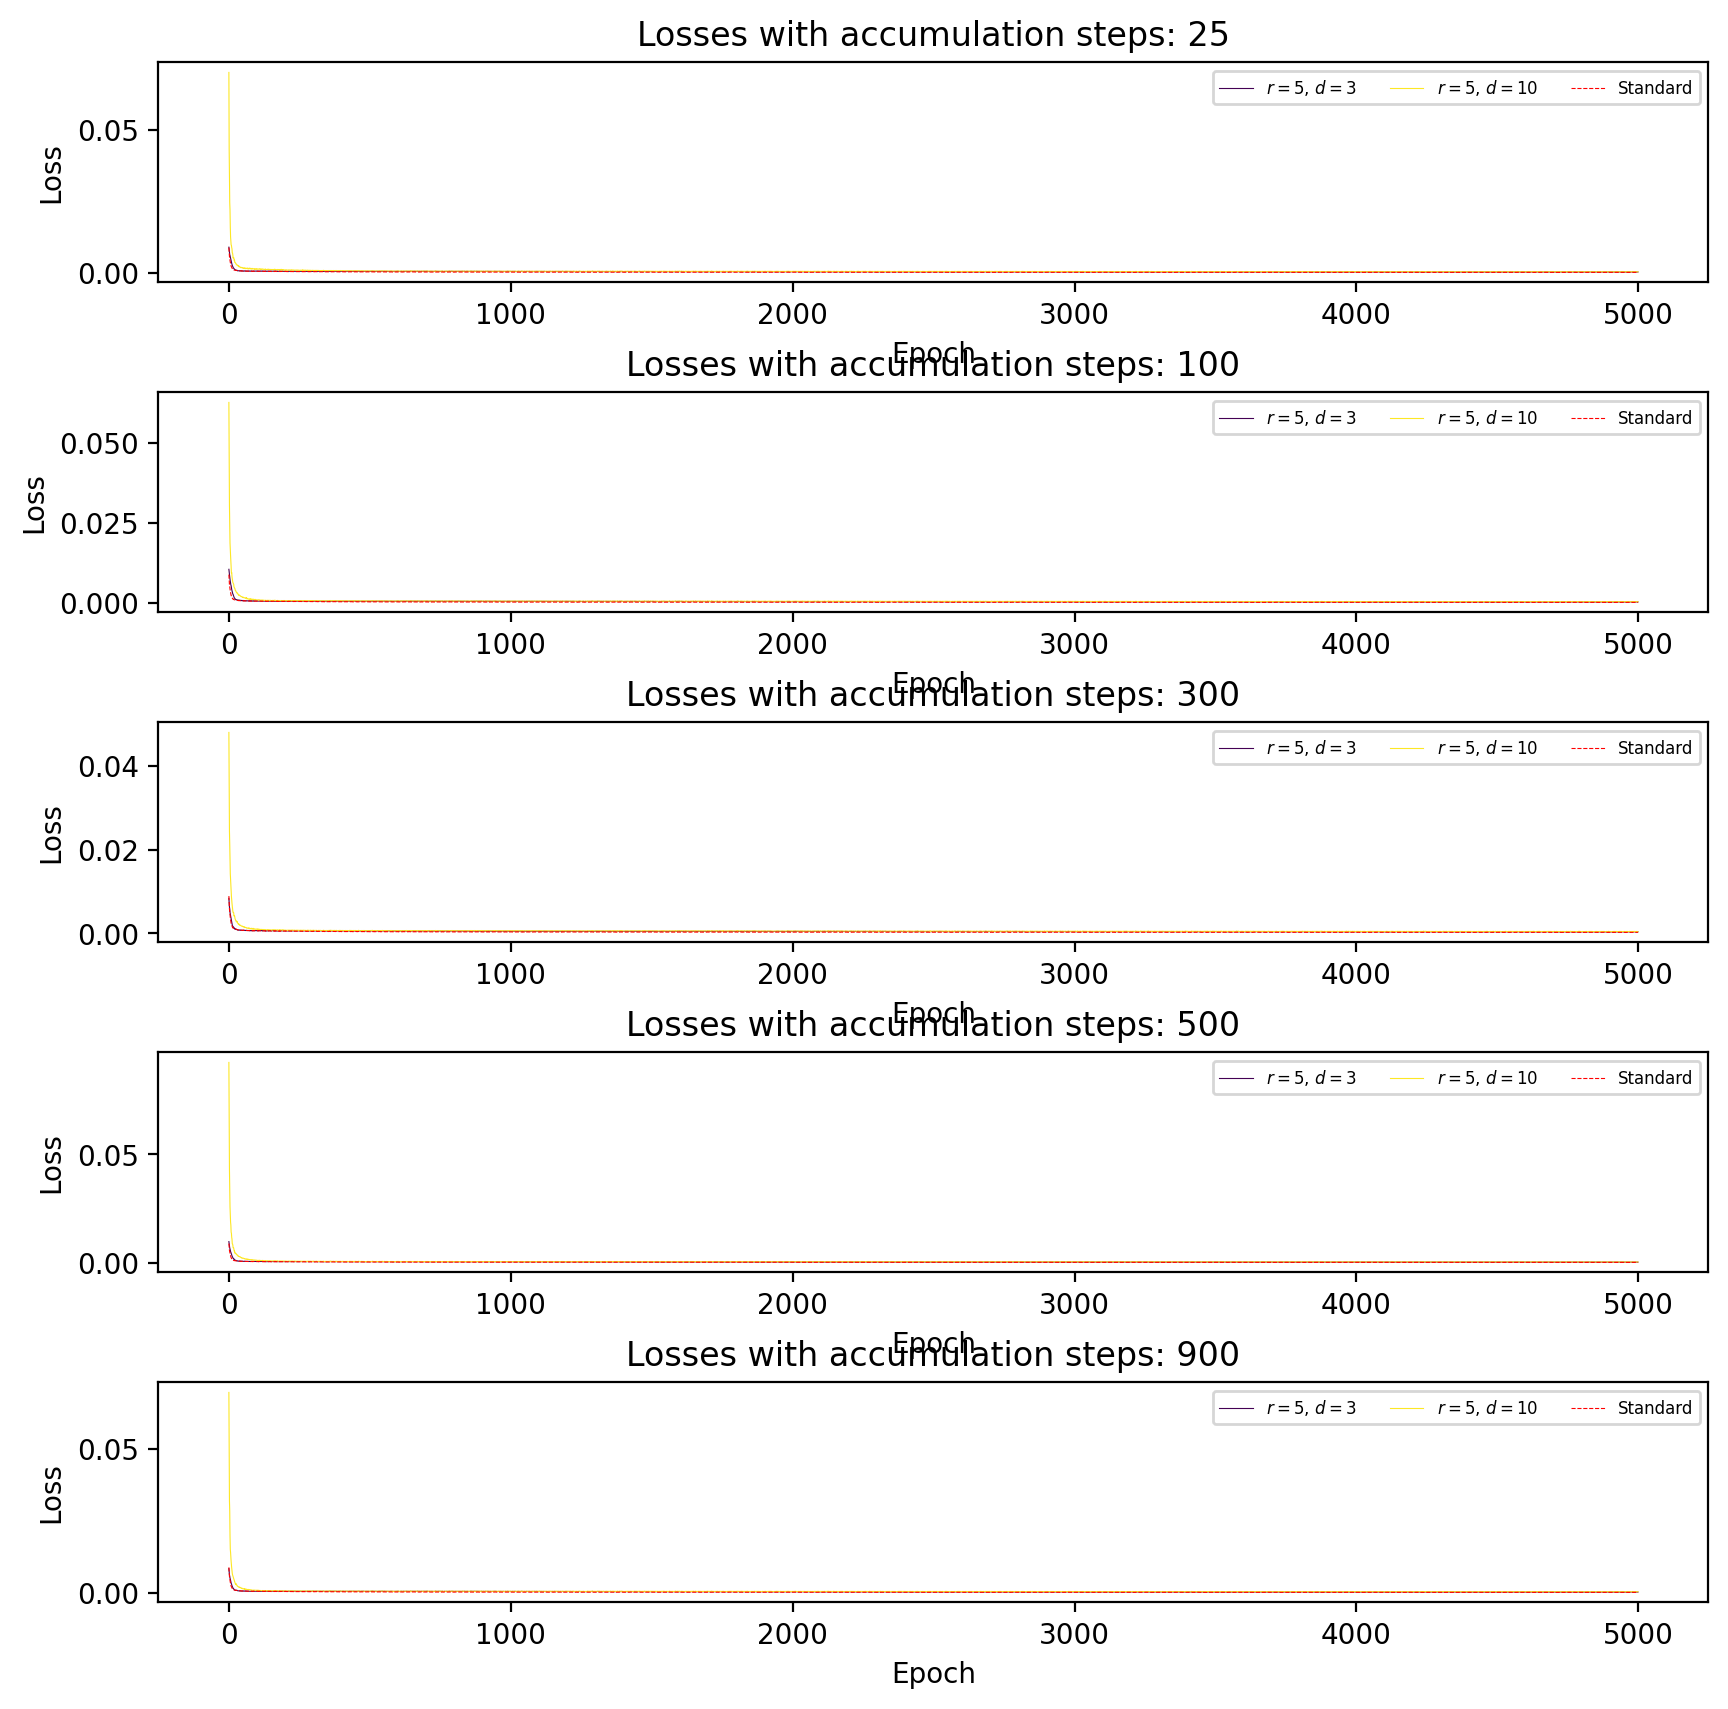

In [25]:
def plot_losses(losses, losses_sow, accumulation_steps):
    plt.rcParams['figure.dpi'] = 200
    
    # For each accumulation step create a new subplot
    fig, axes = plt.subplots(len(accumulation_steps), 1, figsize=(10, 10))
    if len(accumulation_steps) == 1: axes = [axes]

    palette = plt.get_cmap('viridis', len(dict_models.keys()) // len(accumulation_steps))
    for idx, acc_steps in enumerate(accumulation_steps):
        i = 0
        for key in dict_models.keys():
            if key[2] == acc_steps:
                axes[idx].plot(losses_sow[key], label=f"$r={key[0]}$, $d={key[1]}$", lw=0.4, color=palette(i))
                i += 1
        axes[idx].plot(losses, label="Standard", lw=0.4, color='red', linestyle='--')
        # axes[idx].set_xlim(0, 0.02)
        # axes[idx].set_ylim(0, 0.001)
        axes[idx].set_xlabel("Epoch")
        axes[idx].set_ylabel("Loss")
        axes[idx].set_title(f"Losses with accumulation steps: {acc_steps}")
        axes[idx].legend(fontsize=6, loc='upper right', ncol=3)
        fig.subplots_adjust(hspace=0.5)

print(accumulation_steps)
print([l[-1] for l in losses_sow.values()])
plot_losses(losses, losses_sow, accumulation_steps)
plt.show()

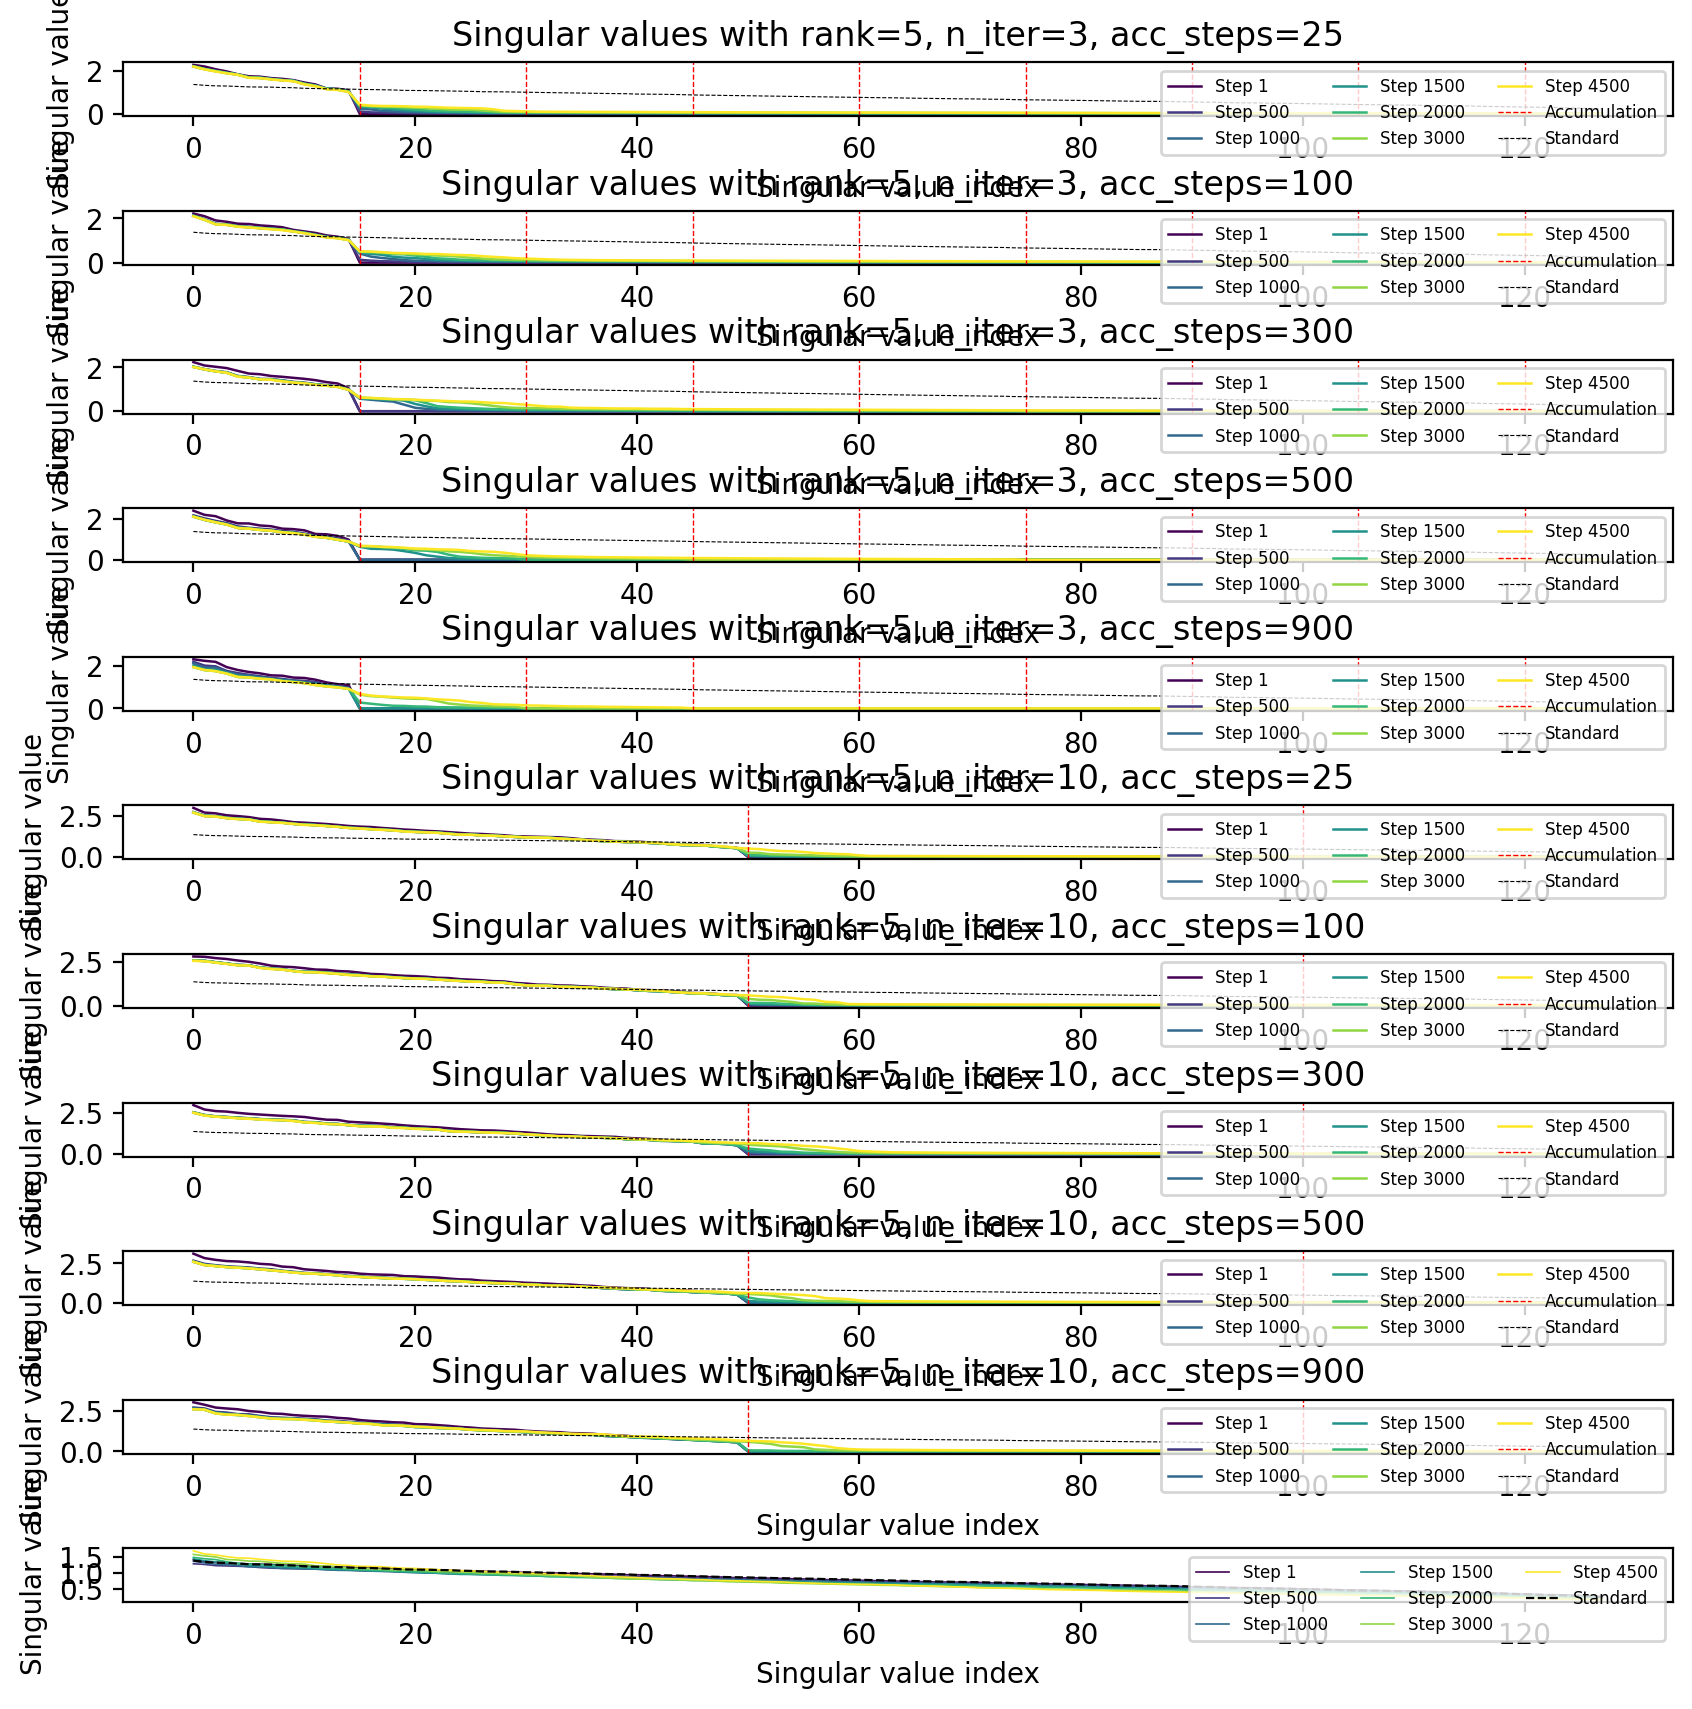

In [24]:
def plot_singular_values(singular_values, singular_values_sow, flash_steps, S, features, weight_idx):
    plt.rcParams['figure.dpi'] = 200

    # random_configs = [(5, 5, 100), (5, 5, 300)]
    random_configs = dict_models.keys()
    n_configs = len(random_configs)

    fig, axes = plt.subplots(n_configs+1, 1, figsize=(10, 10))
    palette2 = plt.get_cmap('plasma', n_configs)

    for idx, conf in enumerate(random_configs):
        rank, n_iter, acc_steps = conf

        sv = [s.cpu().detach().numpy() for s in singular_values_sow[conf]]
        palette = plt.get_cmap('viridis', len(sv))

        for j in range(len(sv)):
            axes[idx].plot(sv[j], color=palette(j), lw=0.9, label=f'Step {flash_steps[j]}')

        for j in range(1, min(features[weight_idx], features[weight_idx+1]) // (rank*n_iter) + 1):
            axes[idx].axvline(x=rank*n_iter*j, color='red', lw=0.5, linestyle='--', label="Accumulation" if j == 1 else None)
        axes[idx].plot(S.cpu().detach().numpy(), color='black', lw=0.4, label='Standard', linestyle='--')
        axes[idx].legend(fontsize=6, loc='upper right', ncol=3)
        axes[idx].set_xlabel("Singular value index")
        axes[idx].set_ylabel("Singular value")
        axes[idx].set_title(f"Singular values with rank={rank}, n_iter={n_iter}, acc_steps={acc_steps}")
        fig.subplots_adjust(hspace=1.75)
        # axes[idx].set_ylim(0, 2.5)

    palette = plt.get_cmap('viridis', len(singular_values))
    for i, sv in enumerate(singular_values):
        axes[n_configs].plot(sv.cpu().detach().numpy(), label=f'Step {flash_steps[i]}', lw=0.6, color=palette(i))
    axes[n_configs].plot(S.cpu().detach().numpy(), color='black', lw=0.8, label='Standard', linestyle='--')
    axes[n_configs].legend(fontsize=6, loc='upper right', ncol=3)
    axes[n_configs].set_xlabel("Singular value index")
    axes[n_configs].set_ylabel("Singular value")

_, S, _ = torch.linalg.svd(ground_model.linears[layer_idx][0].weight)
plot_singular_values(singular_values, singular_values_sow, flash_steps, S, features, layer_idx)

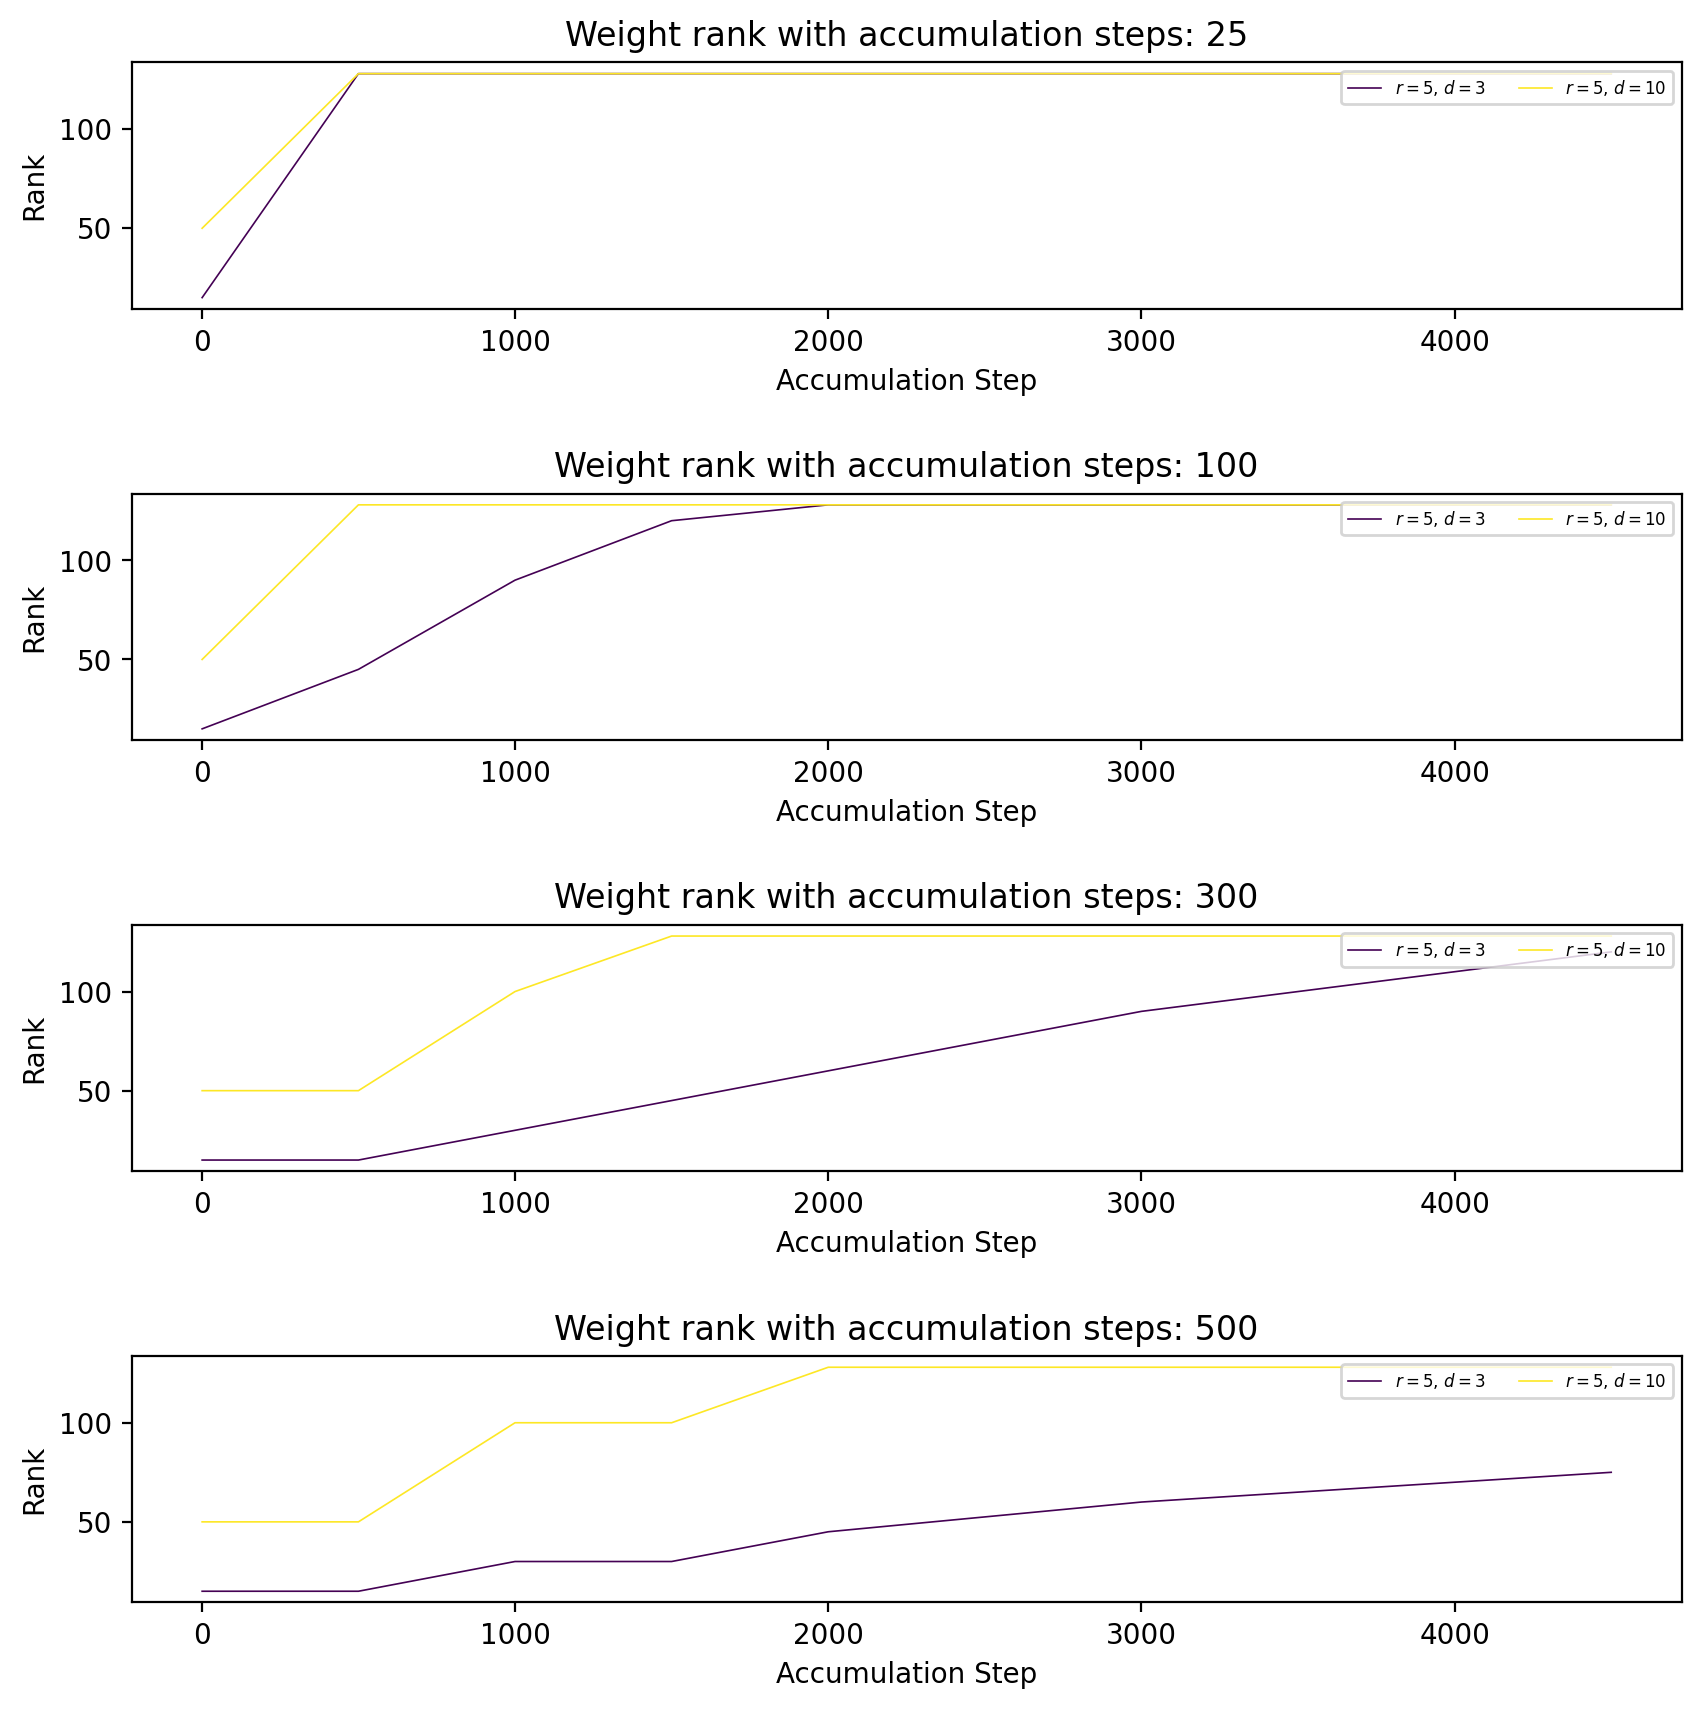

In [23]:
plt.rcParams['figure.dpi'] = 200

fig, axes = plt.subplots(len(accumulation_steps)-1, 1, figsize=(10, 10))
palette = plt.get_cmap('viridis', len(dict_models.keys()) // len(accumulation_steps))

for idx, acc_steps in enumerate(accumulation_steps[:-1]):
    i = 0
    for key in dict_models.keys():
        if key[2] == acc_steps:
            axes[idx].plot(flash_steps[:len(weight_ranks[key])], weight_ranks[key], label=f"$r={key[0]}$, $d={key[1]}$", lw=0.6, color=palette(i))
            i += 1
    axes[idx].set_xlabel("Accumulation Step")
    axes[idx].set_ylabel("Rank")
    axes[idx].set_title(f"Weight rank with accumulation steps: {acc_steps}")
    axes[idx].legend(fontsize=6, loc='upper right', ncol=3)
    fig.subplots_adjust(hspace=0.75)

In [145]:
# x = torch.tensor(np.random.randn(1, features[0]), dtype=torch.float32, requires_grad=False).to('cuda')
x = x_trains[0].unsqueeze(0)
y = ground_model(x).detach().to('cuda')
y_pred = model(x).detach().to('cuda')
y_pred_sow = dict_models[(5, 5, 100)](x).detach().to('cuda')
y_pred_sow2 = dict_models[(5, 5, 300)](x).detach().to('cuda')

print("Standard model prediction: ", y)
print("MLP model prediction: ", y_pred)
print("SoW model prediction: ", y_pred_sow)
print("SoW2 model prediction: ", y_pred_sow2)

Standard model prediction:  tensor([[-4.6400e-02, -5.7534e-05, -7.5029e-02, -1.3488e-01, -4.3988e-02,
         -6.4667e-02,  4.3464e-02, -1.8590e-02,  1.2491e-01, -4.8227e-02,
          6.5107e-02, -3.1770e-02, -2.7634e-02,  3.5140e-02, -6.9694e-02,
         -6.8493e-02,  2.3521e-02,  6.8433e-02,  2.8864e-02,  8.2271e-03,
          5.5673e-02,  9.3748e-02, -2.6193e-02, -1.7389e-02,  4.7403e-02,
          1.7478e-02, -6.9875e-02,  1.0464e-01, -2.8113e-02,  1.1133e-01,
          1.1202e-02,  1.0057e-01]], device='cuda:0')
MLP model prediction:  tensor([[ 0.0002,  0.0012,  0.0756, -0.0625,  0.0739, -0.0095,  0.0062,  0.0161,
          0.0174,  0.0181, -0.0293, -0.0107, -0.0101,  0.1069,  0.0063,  0.1620,
          0.0563, -0.0186,  0.1127,  0.0126, -0.0123, -0.0068,  0.0164, -0.0923,
          0.0411,  0.0310,  0.0544,  0.1195,  0.0041, -0.1031,  0.0216,  0.1221]],
       device='cuda:0')
SoW model prediction:  tensor([[-0.0413,  0.0153, -0.0806, -0.1252, -0.0473, -0.0627,  0.0453, -0.013